### Capstone Project: Part 4

1. Begin with an executive summary:
   - What is your goal?
   - What are your metrics?
   - What were your findings?
   - What risks/limitations/assumptions affect these findings?

2. Walk through your model step by step, starting with EDA
   - What are your variables of interest?
   - What outliers did you remove?
   - What types of data imputation did you perform?

3. Summarize your statistical analysis, including:
   - model selection
   - implementation
   - evaluation
   - inference

4. Clearly document and label each section
   - Logically organize your information in a persuasive, informative manner
   - Include notebook headers and subheaders, as well as clearly formatted markdown for all written components
   - Include graphs/plots/visualizations with clear labels
   - Comment and explain the purpose of each major section/subsection of your code
     - *Document your code for your future self, as if another person needed to replicate your approach*

5. Host your notebook and any other materials in your own public Github Repository
   - Include a technical appendix, including links and explanations to any outside libraries or source code used
   - Host a local copy of your dataset or include a link to a remotely hosted version

#### BONUS
6. Describe how this model could be put into real world production. Consider:
   - How could you continue to validate your model's performance over time?
   - What steps might you need to take to productionize your model for an enterprise environment?
   - How would you deploy your model publicly? What could you do to setup your model and share it online right now?

**1. Executive Summary**

My goal is to successfully create an accurate (above 0.8 accuracy) classification model that can correctly predict whether, in a 3-year window after rehabilitation, an offender  will not return to prison, will go on to break parole, or go on to commit a new offence.

The success metrics for each model I test will be mean CV score, precision score, recall score, f1 score, confusion matrices and ROC surves.


In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn import naive_bayes
from sklearn.preprocessing import PowerTransformer
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

from sklearn.preprocessing import label_binarize

import warnings
import numpy as np
import scipy.stats as stats
from sklearn.tree import DecisionTreeRegressor
from six import StringIO
from sklearn.tree import export_graphviz
import pydotplus
from ipywidgets import *
from IPython.display import display
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc("figure", figsize=(9, 7))
sns.set(font_scale=1.5)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
warnings.simplefilter('ignore')

In [3]:
def plot_f1_lines(figsize=(8, 6), fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)

    # add lines of constant F1 scores

    for const in np.linspace(0.2, 0.9, 8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                    xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

In [4]:
df = pd.read_csv('/Users/darshanasridhar/Documents/Ga Capstone Datasets /Recidivism/recidivism_clean.csv')
df

Year Released  Tracking End  Average Release Age  Recidivism Type  \
0               2010          2013                 29.5                2   
1               2010          2013                 29.5                1   
2               2010          2013                 39.5                1   
3               2010          2013                 29.5                0   
4               2010          2013                 39.5                1   
...              ...           ...                  ...              ...   
26012           2015          2018                 25.0                0   
26013           2015          2018                 39.5                0   
26014           2015          2018                 29.5                0   
26015           2015          2018                 29.5                0   
26016           2015          2018                 39.5                1   

       District_2JD  District_3JD  District_4JD  District_5JD  District_6JD  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             1             0   
3                 0             0             0             0             1   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
26012             0             0             0             0             0   
26013             0             0             0             0             1   
26014             0             0             0             1             0   
26015             0             0             0             1             0   
26016             0             0             0             0             0   

       District_7JD  ...  Offense Subtype_Robbery  Offense Subtype_Sex  \
0                 1  ...                        1                    0   
1                 0  ...                        0                    0   
2                 0  ...                        0                    0   
3                 0  ...                        0                    0   
4                 0  ...                        0                    0   
...             ...  ...                      ...                  ...   
26012             0  ...                        0                    0   
26013             0  ...                        0                    1   
26014             0  ...                        0                    0   
26015             0  ...                        0                    0   
26016             0  ...                        0                    0   

       Offense Subtype_Sex Offender Registry/Residency  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
26012                                                0   
26013                                                0   
26014                                                0   
26015                                                0   
26016                                                0   

       Offense Subtype_Special Sentence Revocation  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
26012                                            0   
26013                                            0   
26014                                            0   
26015              

In [5]:
df_copy = df.copy()
X = df_copy.drop('Recidivism Type', axis=1)

In [6]:
X

Year Released  Tracking End  Average Release Age  District_2JD  \
0               2010          2013                 29.5             0   
1               2010          2013                 29.5             0   
2               2010          2013                 39.5             0   
3               2010          2013                 29.5             0   
4               2010          2013                 39.5             0   
...              ...           ...                  ...           ...   
26012           2015          2018                 25.0             0   
26013           2015          2018                 39.5             0   
26014           2015          2018                 29.5             0   
26015           2015          2018                 29.5             0   
26016           2015          2018                 39.5             0   

       District_3JD  District_4JD  District_5JD  District_6JD  District_7JD  \
0                 0             0             0             0             1   
1                 0             0             0             0             0   
2                 0             0             1             0             0   
3                 0             0             0             1             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
26012             0             0             0             0             0   
26013             0             0             0             1             0   
26014             0             0             1             0             0   
26015             0             0             1             0             0   
26016             0             0             0             0             0   

       District_8JD  ...  Offense Subtype_Robbery  Offense Subtype_Sex  \
0                 0  ...                        1                    0   
1                 0  ...                        0                    0   
2                 0  ...                        0                    0   
3                 0  ...                        0                    0   
4                 0  ...                        0                    0   
...             ...  ...                      ...                  ...   
26012             0  ...                        0                    0   
26013             0  ...                        0                    1   
26014             0  ...                        0                    0   
26015             0  ...                        0                    0   
26016             0  ...                        0                    0   

       Offense Subtype_Sex Offender Registry/Residency  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   
4                                                    0   
...                                                ...   
26012                                                0   
26013                                                0   
26014                                                0   
26015                                                0   
26016                                                0   

       Offense Subtype_Special Sentence Revocation  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   
...                                            ...   
26012                                            0   
26013                                            0   
26014                                            0   
26015                                            0   
2

In [7]:
X.columns

Index(['Year Released', 'Tracking End', 'Average Release Age', 'District_2JD',
       'District_3JD', 'District_4JD', 'District_5JD', 'District_6JD',
       'District_7JD', 'District_8JD', 'District_ISC',
       'District_Interstate Compact', 'District_None Given',
       'Release Type_None Given', 'Release Type_Parole',
       'Release Type_Special Sentence', 'Ethnicity_Non-Hispanic',
       'Ethnicity_None Given', 'Race_Asian or Pacific Islander', 'Race_Black',
       'Race_None Given', 'Race_White', 'Sex_Male', 'Offense Classification_2',
       'Offense Classification_3', 'Offense Classification_4',
       'Offense Classification_5', 'Offense Classification_6',
       'Offense Classification_7', 'Offense Classification_8',
       'Offense Type_Other', 'Offense Type_Property',
       'Offense Type_Public Order', 'Offense Type_Violent',
       'Offense Subtype_Animals', 'Offense Subtype_Arson',
       'Offense Subtype_Assault', 'Offense Subtype_Burglary',
       'Offense Subtype_Drug

In [8]:
y = df.pop('Recidivism Type')

In [9]:
y

0        2
1        1
2        1
3        0
4        1
        ..
26012    0
26013    0
26014    0
26015    0
26016    1
Name: Recidivism Type, Length: 26017, dtype: int64

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10, stratify = y)
print(X_train.shape, y_train.shape)
print( X_test.shape, y_test.shape)

(20813, 59) (20813,)
(5204, 59) (5204,)


In [11]:
X_train

Year Released  Tracking End  Average Release Age  District_2JD  \
24067           2015          2018                 25.0             0   
19468           2014          2017                 39.5             0   
6171            2011          2014                 29.5             0   
3935            2011          2014                 29.5             0   
11643           2012          2015                 49.5             0   
...              ...           ...                  ...           ...   
11350           2012          2015                 25.0             0   
17660           2014          2017                 39.5             0   
17507           2014          2017                 29.5             0   
21112           2014          2017                 39.5             0   
17765           2014          2017                 49.5             0   

       District_3JD  District_4JD  District_5JD  District_6JD  District_7JD  \
24067             0             0             0             0             0   
19468             0             0             0             0             0   
6171              0             0             0             0             0   
3935              0             0             0             0             0   
11643             0             0             1             0             0   
...             ...           ...           ...           ...           ...   
11350             0             0             0             0             0   
17660             0             0             0             0             0   
17507             0             0             0             0             0   
21112             1             0             0             0             0   
17765             0             0             0             0             0   

       District_8JD  ...  Offense Subtype_Robbery  Offense Subtype_Sex  \
24067             0  ...                        0                    0   
19468             0  ...                        0                    0   
6171              0  ...                        0                    0   
3935              0  ...                        0                    0   
11643             0  ...                        0                    0   
...             ...  ...                      ...                  ...   
11350             0  ...                        0                    0   
17660             0  ...                        0                    0   
17507             0  ...                        0                    0   
21112             0  ...                        0                    0   
17765             0  ...                        0                    0   

       Offense Subtype_Sex Offender Registry/Residency  \
24067                                                0   
19468                                                0   
6171                                                 0   
3935                                                 0   
11643                                                0   
...                                                ...   
11350                                                0   
17660                                                0   
17507                                                0   
21112                                                0   
17765                                                0   

       Offense Subtype_Special Sentence Revocation  \
24067                                            0   
19468                                            0   
6171                                             0   
3935                                             0   
11643                                            0   
...                                            ...   
11350                                            0   
17660                                            0   
17507                                            0   
21112                                            0   
1

In [12]:
y_train

24067    0
19468    0
6171     0
3935     0
11643    1
        ..
11350    0
17660    0
17507    2
21112    1
17765    0
Name: Recidivism Type, Length: 20813, dtype: int64

In [13]:
y_test.value_counts(normalize=True)

0    0.666410
2    0.211952
1    0.121637
Name: Recidivism Type, dtype: float64

In [14]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

In [15]:
#Check that all indeces of training X match all indeces of training y
np.allclose(X_train.index, y_train.index)

True

In [15]:
#Baseline
y.value_counts(normalize=True)
print('Baseline - Predict Class 0:', y.value_counts(normalize=True).max())

Baseline - Predict Class 0: 0.6663335511396394


In [16]:
print('Baseline:', y.value_counts(normalize=True))

Baseline: 0    0.666334
2    0.212015
1    0.121651
Name: Recidivism Type, dtype: float64


In [17]:
#Model 1
model_1 = LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=1000) 

model_1.fit(X_train, y_train)

train_predictions_1 = model_1.predict(X_train)
test_predictions_1 = model_1.predict(X_test)
probabilities_1 = model_1.predict_proba(X_test)

#print('Accuracy score', model_1.score(scaler.transform(X), y))
print('Precision score', precision_score(y_test, test_predictions_1, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_1, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_1, average='micro'))

print('Training score', model_1.score(X_train, y_train))
print('Testing score', model_1.score(X_test, y_test))

cv_scores = cross_val_score(model_1, X_train, y_train, cv=5)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))
print(np.unique(test_predictions_1))

coefficients_1 = model_1.coef_

Precision score 0.6654496541122213
Recall score 0.6654496541122213
F1 score 0.6654496541122213
Training score 0.6684283861048383
Testing score 0.6654496541122213
CV scores [0.67643526 0.66202258 0.66946913 0.66338299 0.66770783]
Mean CV Score 0.6678035594917955
[0 1 2]


In [18]:
print(confusion_matrix(y_test, test_predictions_1, labels=[0, 1, 2]))

[[3391   14   63]
 [ 611   15    7]
 [1035   11   57]]


In [19]:
print(classification_report(y_train, train_predictions_1, digits=4))

              precision    recall  f1-score   support

           0     0.6740    0.9800    0.7987     13868
           1     0.4888    0.0344    0.0642      2532
           2     0.4979    0.0533    0.0962      4413

    accuracy                         0.6684     20813
   macro avg     0.5536    0.3559    0.3197     20813
weighted avg     0.6141    0.6684    0.5604     20813



In [20]:
print(classification_report(y_test, test_predictions_1, digits=4))

              precision    recall  f1-score   support

           0     0.6732    0.9778    0.7974      3468
           1     0.3750    0.0237    0.0446       633
           2     0.4488    0.0517    0.0927      1103

    accuracy                         0.6654      5204
   macro avg     0.4990    0.3511    0.3116      5204
weighted avg     0.5894    0.6654    0.5565      5204



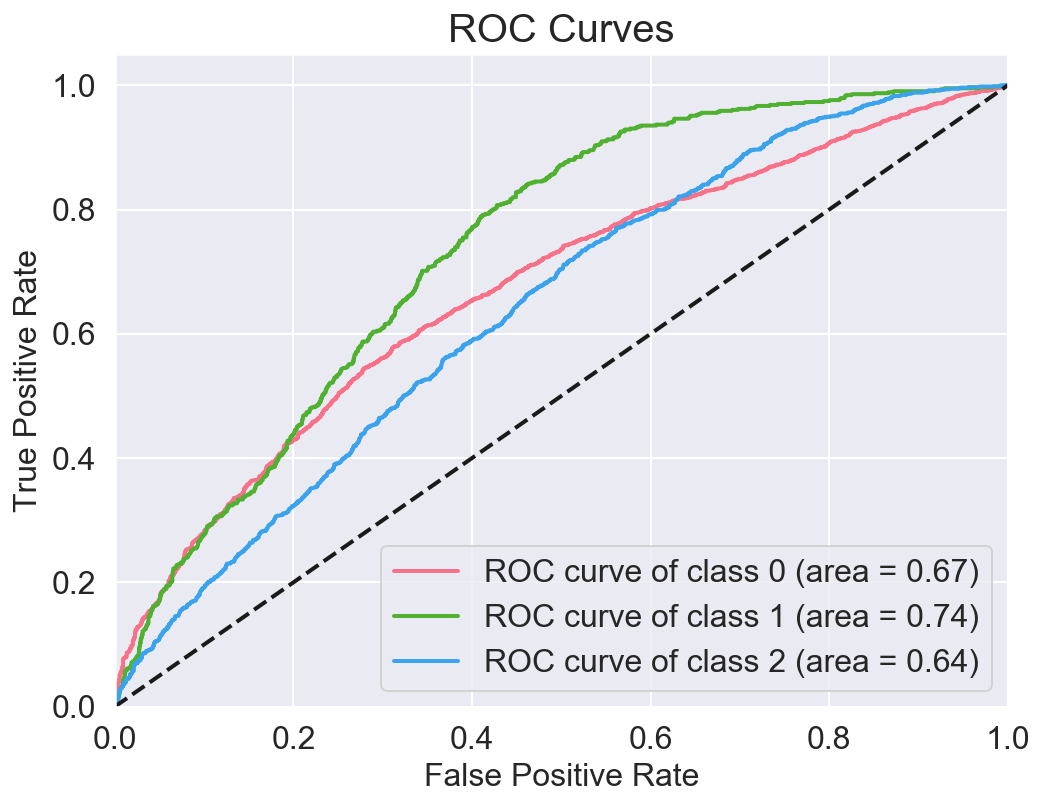

Area under ROC curve (ROC-AUC):
Class 0: 0.67
Class 1: 0.74
Class 2: 0.64


In [21]:
#ROC curve for Model 1
y_test_bin_1 = label_binarize(y_test, model_1.classes_)

skplt.metrics.plot_roc(y_test, model_1.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(model_1.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_1[:, i], model_1.predict_proba(X_test)[:, i]), 2))

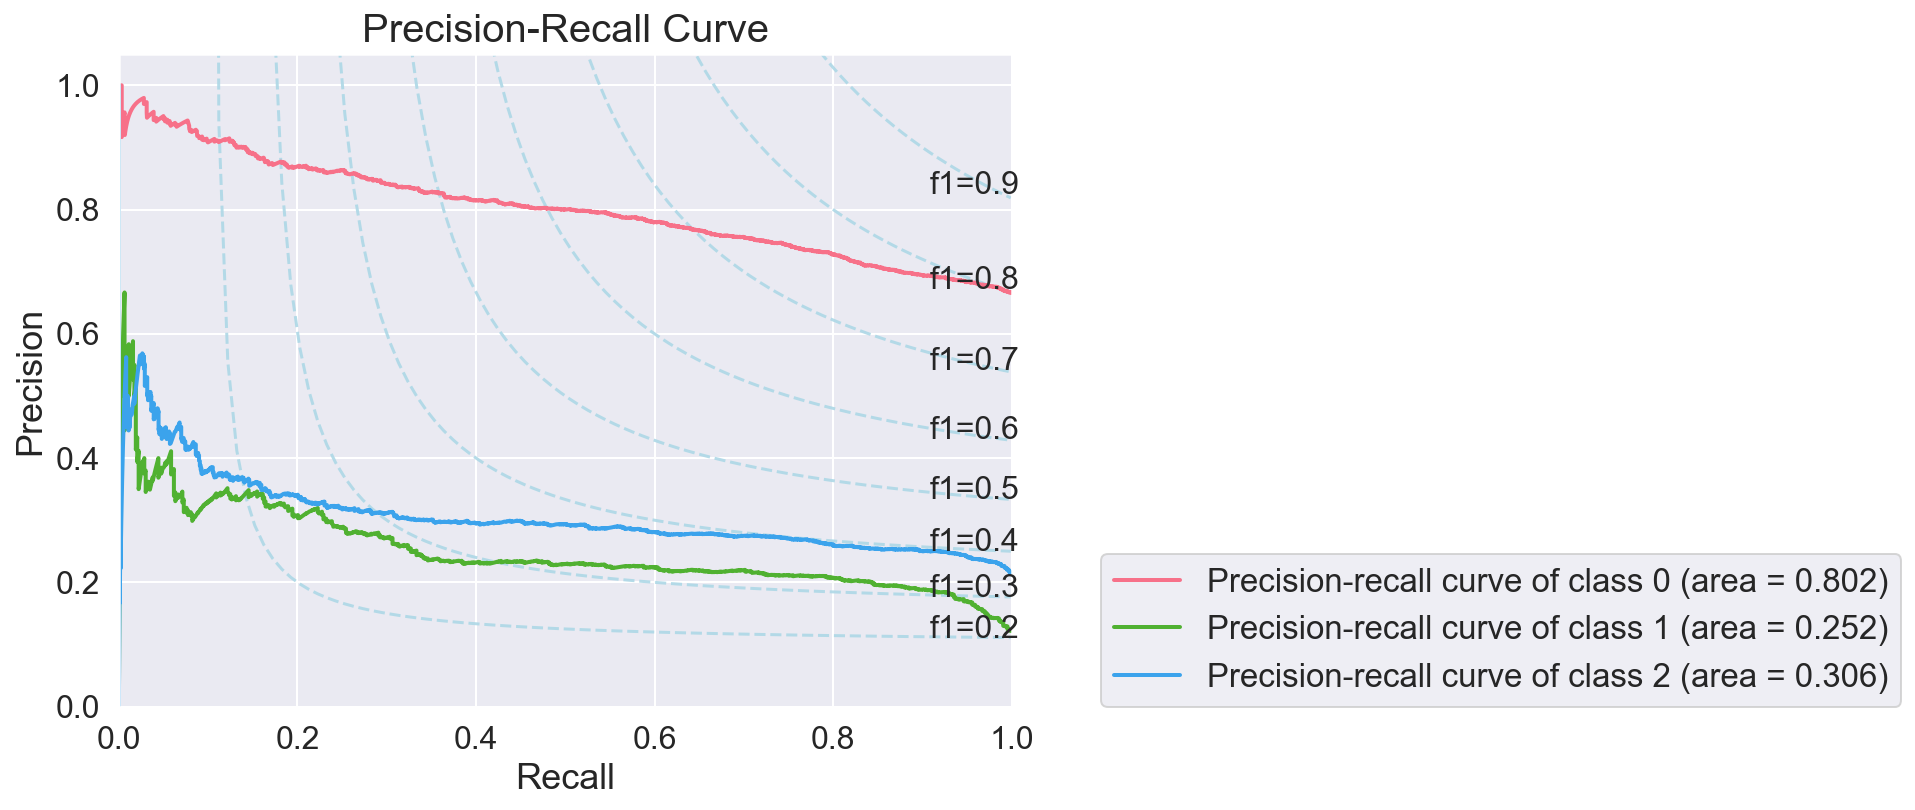

Area under precision-recall curve:
Class 0: 0.8021
Class 1: 0.2516
Class 2: 0.3059


In [22]:
#Precision-Recall curve for Model 1
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_1.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(model_1.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_1[:, i], model_1.predict_proba(X_test)[:, i]), 4))

In [23]:
#Model 2
model_2 = LogisticRegressionCV(solver='liblinear',
                               multi_class='ovr', cv=5, max_iter=1000, class_weight={0:10000000,1:10000000,2:.1})

model_2.fit(X_train, y_train)

train_predictions_2 = model_2.predict(X_train)
test_predictions_2 = model_2.predict(X_test)
probabilities_2 = model_2.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_2, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_2, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_2, average='micro'))

print('Training score', model_2.score(X_train, y_train))
print('Testing score', model_2.score(X_test, y_test))

cv_scores = cross_val_score(model_2, X_train, y_train, cv=5)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

coefficients_2 = model_2.coef_

Precision score 0.6660261337432744
Recall score 0.6660261337432744
F1 score 0.6660261337432744
Training score 0.667323307548167
Testing score 0.6660261337432744
CV scores [0.66850829 0.66610617 0.66778765 0.66602595 0.66674676]
Mean CV Score 0.6670349638580557


In [24]:
np.unique(test_predictions_2)

array([0, 1])

In [25]:
print(confusion_matrix(y_test, test_predictions_2, labels=[0, 1, 2]))

[[3446   22    0]
 [ 613   20    0]
 [1082   21    0]]


In [26]:
print(classification_report(y_train, train_predictions_2, digits=4))

              precision    recall  f1-score   support

           0     0.6699    0.9939    0.8004     13868
           1     0.4435    0.0419    0.0765      2532
           2     0.0000    0.0000    0.0000      4413

    accuracy                         0.6673     20813
   macro avg     0.3711    0.3452    0.2923     20813
weighted avg     0.5003    0.6673    0.5426     20813



In [27]:
print(classification_report(y_test, test_predictions_2, digits=4))

              precision    recall  f1-score   support

           0     0.6703    0.9937    0.8006      3468
           1     0.3175    0.0316    0.0575       633
           2     0.0000    0.0000    0.0000      1103

    accuracy                         0.6660      5204
   macro avg     0.3293    0.3418    0.2860      5204
weighted avg     0.4853    0.6660    0.5405      5204



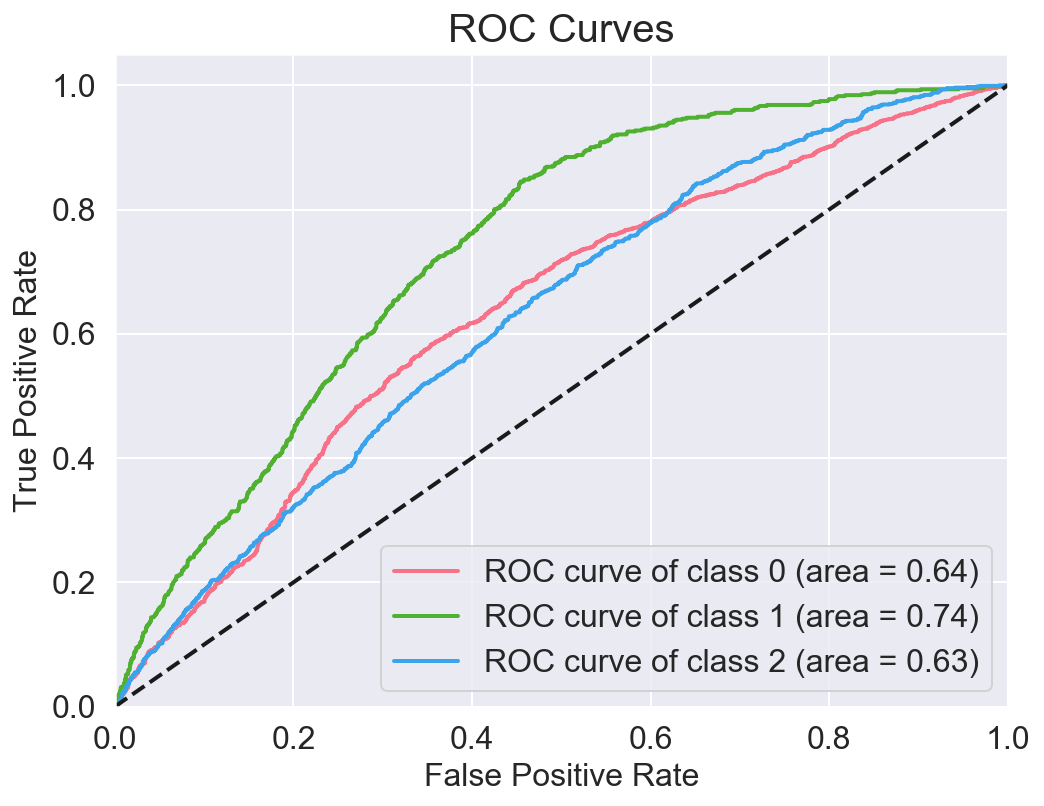

Area under ROC curve (ROC-AUC):
Class 0: 0.64
Class 1: 0.74
Class 2: 0.63


In [28]:
#ROC curve for Model 2
y_test_bin_2 = label_binarize(y_test, model_2.classes_)

skplt.metrics.plot_roc(y_test, model_2.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(model_1.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_2[:, i], model_2.predict_proba(X_test)[:, i]), 2))

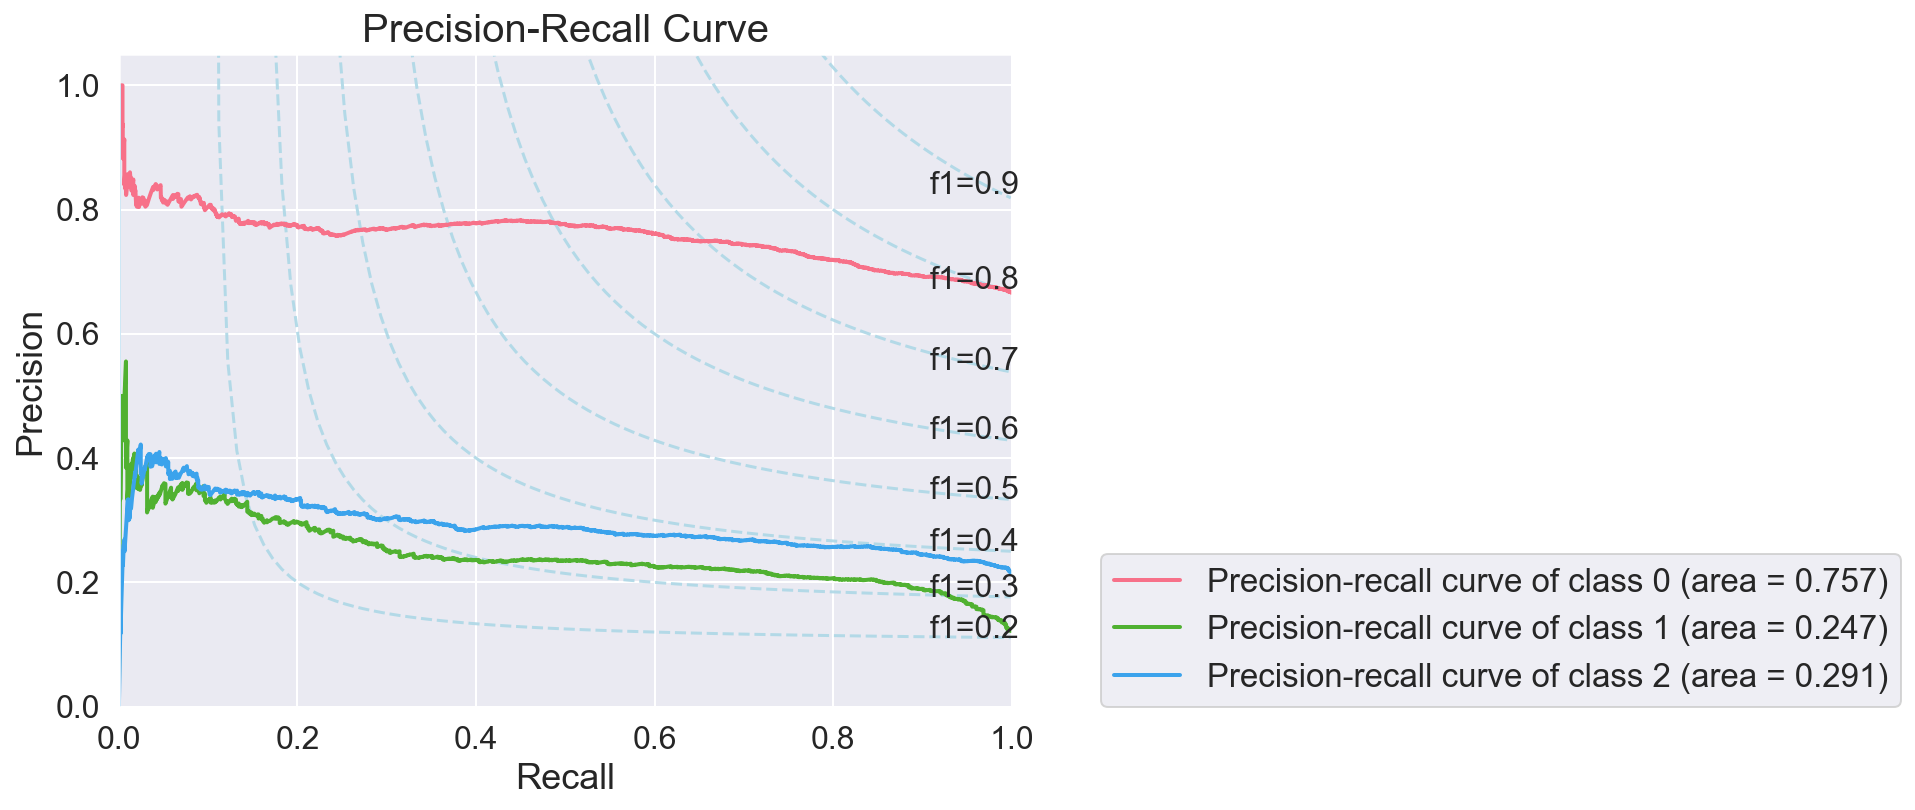

Area under precision-recall curve:
Class 0: 0.7573
Class 1: 0.2465
Class 2: 0.291


In [29]:
#Precision-Recall curve for Model 2
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_2.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(model_2.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_2[:, i], model_2.predict_proba(X_test)[:, i]), 4))

Out of LogReg and LogRegCV, LogReg had higher mean CV score. Tune using model_1 with different regularisation parameters

In [30]:
#Start with Ridge:
model_1_ridge = LogisticRegression(penalty = 'l2', solver='saga', max_iter=100)
model_1_ridge.fit(X_train, y_train)
print('Training score', model_1_ridge.score(X_train, y_train))
print('Testing score', model_1_ridge.score(X_test, y_test))
print('Mean CV Score', cross_val_score(model_1_ridge, X_train, y_train, cv=5).mean())

Training score 0.6686686205736799
Testing score 0.6658339738662568
Mean CV Score 0.6680438401362636


In [31]:
#Now tune for Lasso:
model_1_lasso = LogisticRegression(penalty = 'l1', max_iter=100, solver= 'liblinear')
model_1_lasso.fit(X_train, y_train)
print('Training score', model_1_lasso.score(X_train, y_train))
print('Testing score', model_1_lasso.score(X_test, y_test))
print('Mean CV Score', cross_val_score(model_1_lasso, X_train, y_train, cv=5).mean())

Training score 0.6684283861048383
Testing score 0.6652574942352036
Mean CV Score 0.6679957632298354


In [32]:
#Now tune for ElasticNet:
model_1_en = LogisticRegression(penalty = 'elasticnet', l1_ratio=1, solver='saga', max_iter=1000)
model_1_en.fit(X_train, y_train)
print('Training score', model_1_en.score(X_train, y_train))
print('Testing score', model_1_en.score(X_test, y_test))
print('Mean CV Score', cross_val_score(model_1_en, X_train, y_train, cv=5).mean())

Training score 0.6686686205736799
Testing score 0.6660261337432744
Mean CV Score 0.6680919054996172


Out of the 3 regularisation strengths, Lasso performed best - highest mean CV score.

In [33]:
#Model 3 - KNN
knn = KNeighborsClassifier(n_neighbors=50, metric='cosine') #mostly dummy vars so use cosine

knn.fit(X_train, y_train)

train_predictions_knn = knn.predict(X_train)
test_predictions_knn = knn.predict(X_test)
probabilities_knn = knn.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_knn, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_knn, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_knn, average='micro'))

print('Training score', knn.score(X_train, y_train))
print('Testing score', knn.score(X_test, y_test))

cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

#KNN is nonparametric so has no attribute to finding coefficients.

Precision score 0.6660261337432744
Recall score 0.6660261337432744
F1 score 0.6660261337432744
Training score 0.6695334646615096
Testing score 0.6660261337432744
CV scores [0.66634638 0.66538554 0.66754744 0.66530514 0.66242191]
Mean CV Score 0.6654012840285515


In [34]:
np.unique(test_predictions_knn)

array([0, 1, 2])

In [35]:
print(confusion_matrix(y_test, test_predictions_knn, labels=[0, 1, 2]))

[[3419   16   33]
 [ 602   15   16]
 [1063    8   32]]


In [36]:
print(classification_report(y_train, train_predictions_knn, digits=4))

              precision    recall  f1-score   support

           0     0.6747    0.9882    0.8019     13868
           1     0.5135    0.0300    0.0567      2532
           2     0.4375    0.0349    0.0646      4413

    accuracy                         0.6695     20813
   macro avg     0.5419    0.3511    0.3078     20813
weighted avg     0.6048    0.6695    0.5549     20813



In [37]:
print(classification_report(y_test, test_predictions_knn, digits=4))

              precision    recall  f1-score   support

           0     0.6725    0.9859    0.7996      3468
           1     0.3846    0.0237    0.0446       633
           2     0.3951    0.0290    0.0541      1103

    accuracy                         0.6660      5204
   macro avg     0.4841    0.3462    0.2994      5204
weighted avg     0.5787    0.6660    0.5497      5204



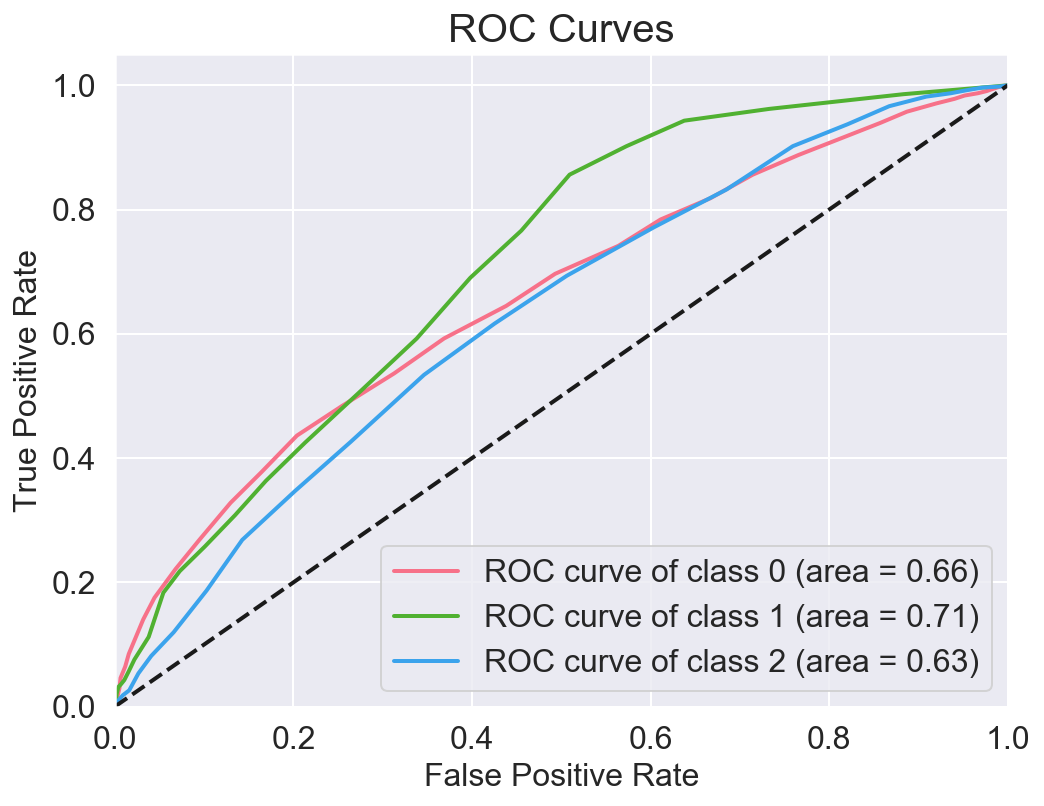

Area under ROC curve (ROC-AUC):
Class 0: 0.66
Class 1: 0.71
Class 2: 0.63


In [38]:
#ROC curve for Model 3
y_test_bin_3 = label_binarize(y_test, knn.classes_)

skplt.metrics.plot_roc(y_test, knn.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(knn.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_3[:, i], knn.predict_proba(X_test)[:, i]), 2))

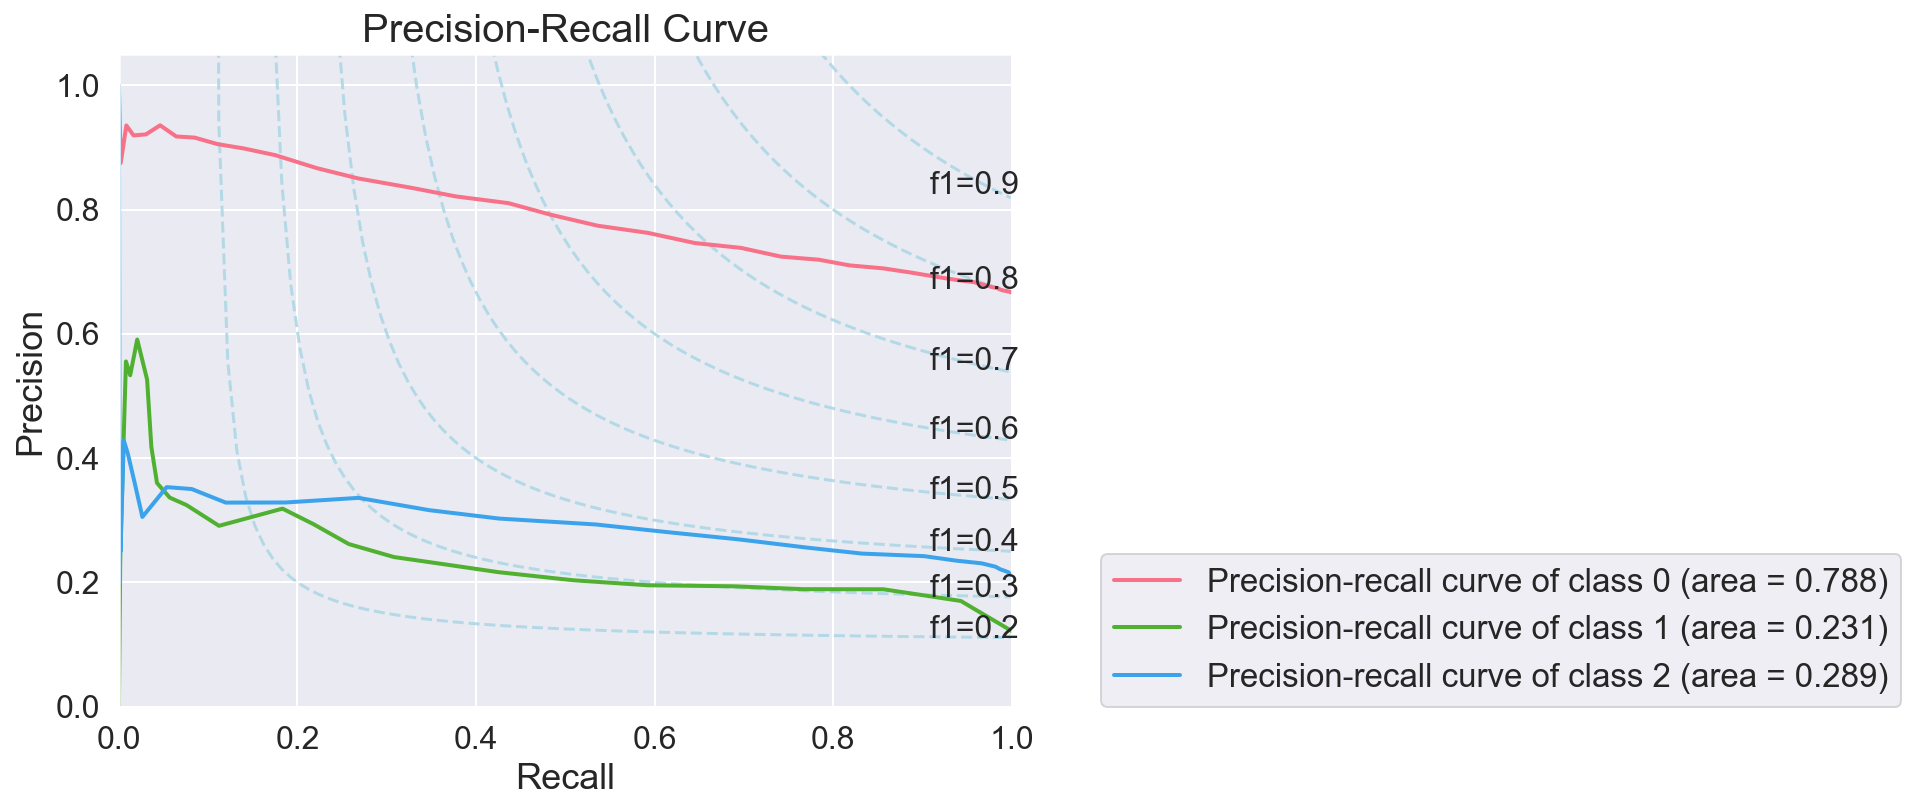

Area under precision-recall curve:
Class 0: 0.7884
Class 1: 0.2307
Class 2: 0.2892


In [39]:
#Precision-Recall curve for Model 3
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, knn.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(knn.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_3[:, i], knn.predict_proba(X_test)[:, i]), 4))

In [40]:
#Model 4 - Decision Tree Classifier 
dt_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)

dt_classifier.fit(X_train, y_train)

train_predictions_dt = dt_classifier.predict(X_train)
test_predictions_dt = dt_classifier.predict(X_test)
probabilities_dt = dt_classifier.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_dt, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_dt, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_dt, average='micro'))

print('Training score', dt_classifier.score(X_train, y_train))
print('Testing score', dt_classifier.score(X_test, y_test))

cv_scores = cross_val_score(dt_classifier, X_train, y_train, cv=5)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

#Decision Tree is nonparametric so no coefficient parameter

Precision score 0.5978093774019985
Recall score 0.5978093774019985
F1 score 0.5978093774019985
Training score 0.8187190698121366
Testing score 0.5978093774019985
CV scores [0.59740572 0.60317079 0.60004804 0.58962037 0.59586737]
Mean CV Score 0.5972224591758961


criterion = entropy performed better (Mean CV score of 0.5978465906705617 ) than criterion = gini (mean CV score of 0.5954924496128353)

In [41]:
np.unique(test_predictions_dt)

array([0, 1, 2])

In [42]:
print(confusion_matrix(y_test, test_predictions_dt, labels=[0, 1, 2]))

[[2785  258  425]
 [ 449  109   75]
 [ 796   90  217]]


In [43]:
print(classification_report(y_train, train_predictions_dt, digits=4))

              precision    recall  f1-score   support

           0     0.8114    0.9738    0.8852     13868
           1     0.8367    0.5604    0.6712      2532
           2     0.8557    0.4797    0.6148      4413

    accuracy                         0.8187     20813
   macro avg     0.8346    0.6713    0.7237     20813
weighted avg     0.8239    0.8187    0.8018     20813



In [44]:
print(classification_report(y_test, test_predictions_dt, digits=4))

              precision    recall  f1-score   support

           0     0.6911    0.8031    0.7429      3468
           1     0.2385    0.1722    0.2000       633
           2     0.3026    0.1967    0.2385      1103

    accuracy                         0.5978      5204
   macro avg     0.4107    0.3907    0.3938      5204
weighted avg     0.5537    0.5978    0.5699      5204



In [45]:
pd.DataFrame(list(zip(X_train, dt_classifier.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)

Feature  Importance
2        Average Release Age    0.131671
0              Year Released    0.069266
12       District_None Given    0.064635
22                  Sex_Male    0.047937
1               Tracking End    0.045767
21                Race_White    0.040975
19                Race_Black    0.039473
16    Ethnicity_Non-Hispanic    0.030404
3               District_2JD    0.029607
27  Offense Classification_6    0.028246

In [ ]:
feature_names = X.columns

dot_data = StringIO()
export_graphviz(dt_classifier, out_file=dot_data, filled=True, rounded=True, 
                special_characters=True, feature_names=feature_names)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

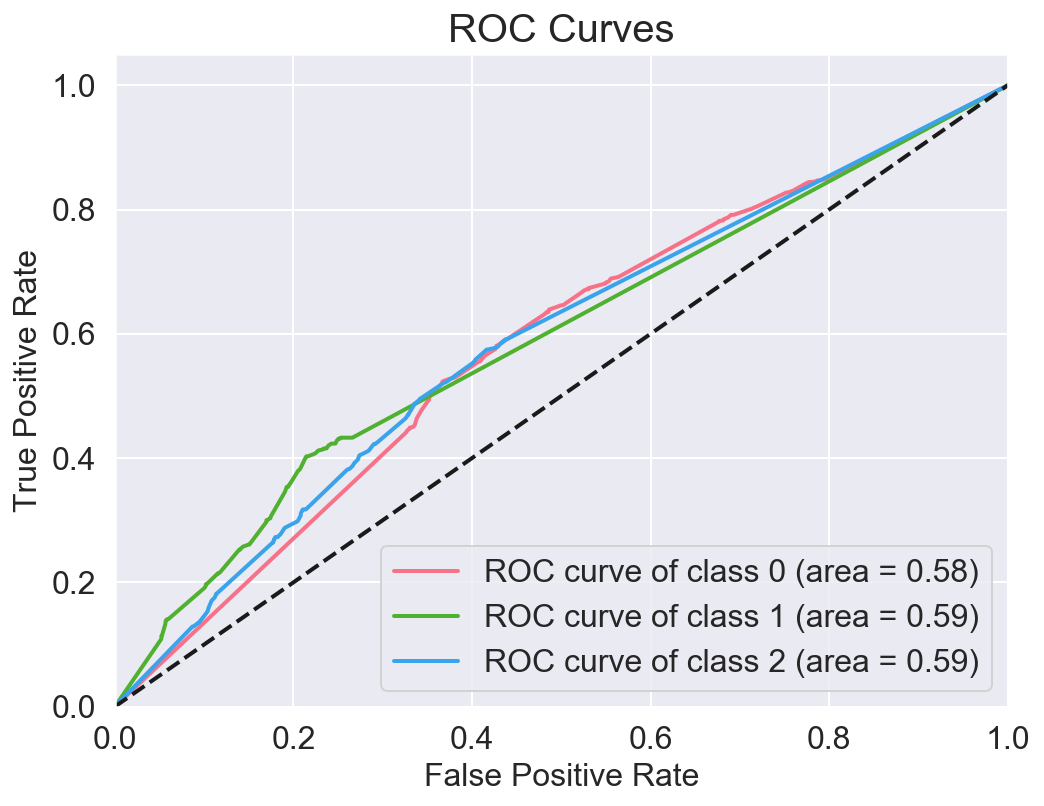

Area under ROC curve (ROC-AUC):
Class 0: 0.58
Class 1: 0.59
Class 2: 0.59


In [47]:
#ROC curve for Model 4
y_test_bin_4 = label_binarize(y_test, dt_classifier.classes_)

skplt.metrics.plot_roc(y_test, dt_classifier.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(dt_classifier.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_4[:, i], dt_classifier.predict_proba(X_test)[:, i]), 2))

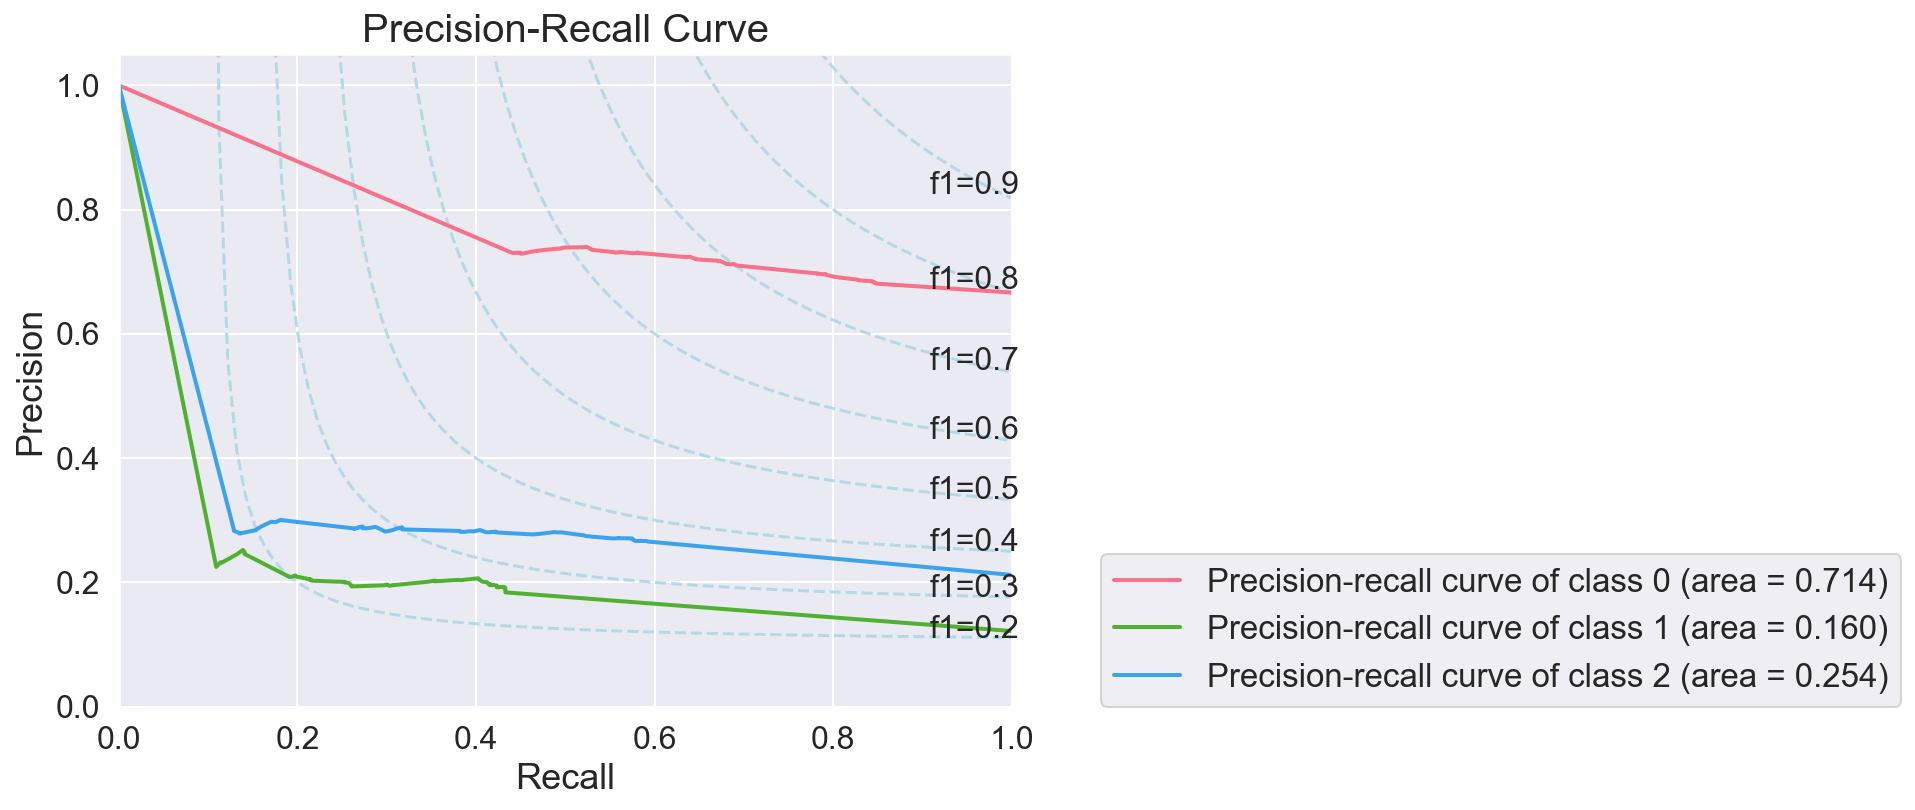

Area under precision-recall curve:
Class 0: 0.7142
Class 1: 0.1602
Class 2: 0.2536


In [48]:
#Precision-Recall curve for Model 4
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, dt_classifier.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(dt_classifier.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_4[:, i], dt_classifier.predict_proba(X_test)[:, i]), 4))

In [49]:
#Model 5 - KNN bagging
knn_bagging = BaggingClassifier(base_estimator=knn, max_samples=0.5, max_features=0.5)

knn_bagging.fit(X_train, y_train)

train_predictions_knn_bag = knn_bagging.predict(X_train)
test_predictions_knn_bag = knn_bagging.predict(X_test)
probabilities_knn_bag = knn_bagging.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_knn_bag, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_knn_bag, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_knn_bag, average='micro'))

print("Training score:\t", knn_bagging.score(X_train, y_train))
print("Test score:\t", knn_bagging.score(X_test, y_test))

cv_scores = cross_val_score(knn_bagging, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6664104534973098
Recall score 0.6664104534973098
F1 score 0.6664104534973098
Training score:	 0.6665065103541056
Test score:	 0.6664104534973098
CV scores [0.66682681 0.66634638 0.66634638 0.66626622 0.66626622]
Mean CV Score 0.6664104027113298


In [50]:
knn_bagging_base_estimator = knn_bagging.base_estimator_

knn_bagging_all_base_estimators = knn_bagging.estimators_

knn_bagging_estimators_features = knn_bagging.estimators_features_

samples = knn_bagging.estimators_samples_

In [51]:
np.unique(test_predictions_knn_bag)

array([0, 1])

In [52]:
print(confusion_matrix(y_test, test_predictions_knn_bag, labels=[0, 1, 2]))

[[3467    1    0]
 [ 632    1    0]
 [1103    0    0]]


In [53]:
print(classification_report(y_train, train_predictions_knn_bag, digits=4))

              precision    recall  f1-score   support

           0     0.6664    1.0000    0.7998     13868
           1     1.0000    0.0016    0.0032      2532
           2     0.0000    0.0000    0.0000      4413

    accuracy                         0.6665     20813
   macro avg     0.5555    0.3339    0.2677     20813
weighted avg     0.5657    0.6665    0.5333     20813



In [54]:
print(classification_report(y_test, test_predictions_knn_bag, digits=4))

              precision    recall  f1-score   support

           0     0.6665    0.9997    0.7998      3468
           1     0.5000    0.0016    0.0031       633
           2     0.0000    0.0000    0.0000      1103

    accuracy                         0.6664      5204
   macro avg     0.3888    0.3338    0.2676      5204
weighted avg     0.5050    0.6664    0.5334      5204



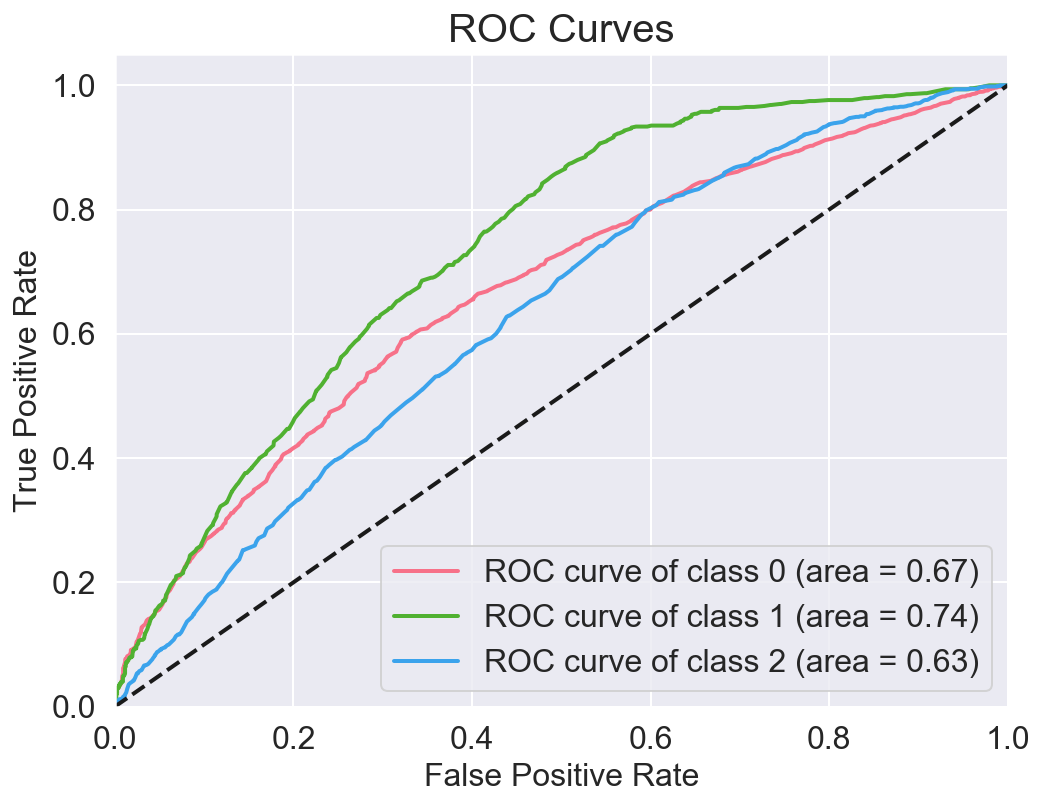

Area under ROC curve (ROC-AUC):
Class 0: 0.67
Class 1: 0.74
Class 2: 0.63


In [55]:
#ROC curve for Model 5
y_test_bin_5 = label_binarize(y_test, knn_bagging.classes_)

skplt.metrics.plot_roc(y_test, knn_bagging.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(knn_bagging.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_5[:, i], knn_bagging.predict_proba(X_test)[:, i]), 2))

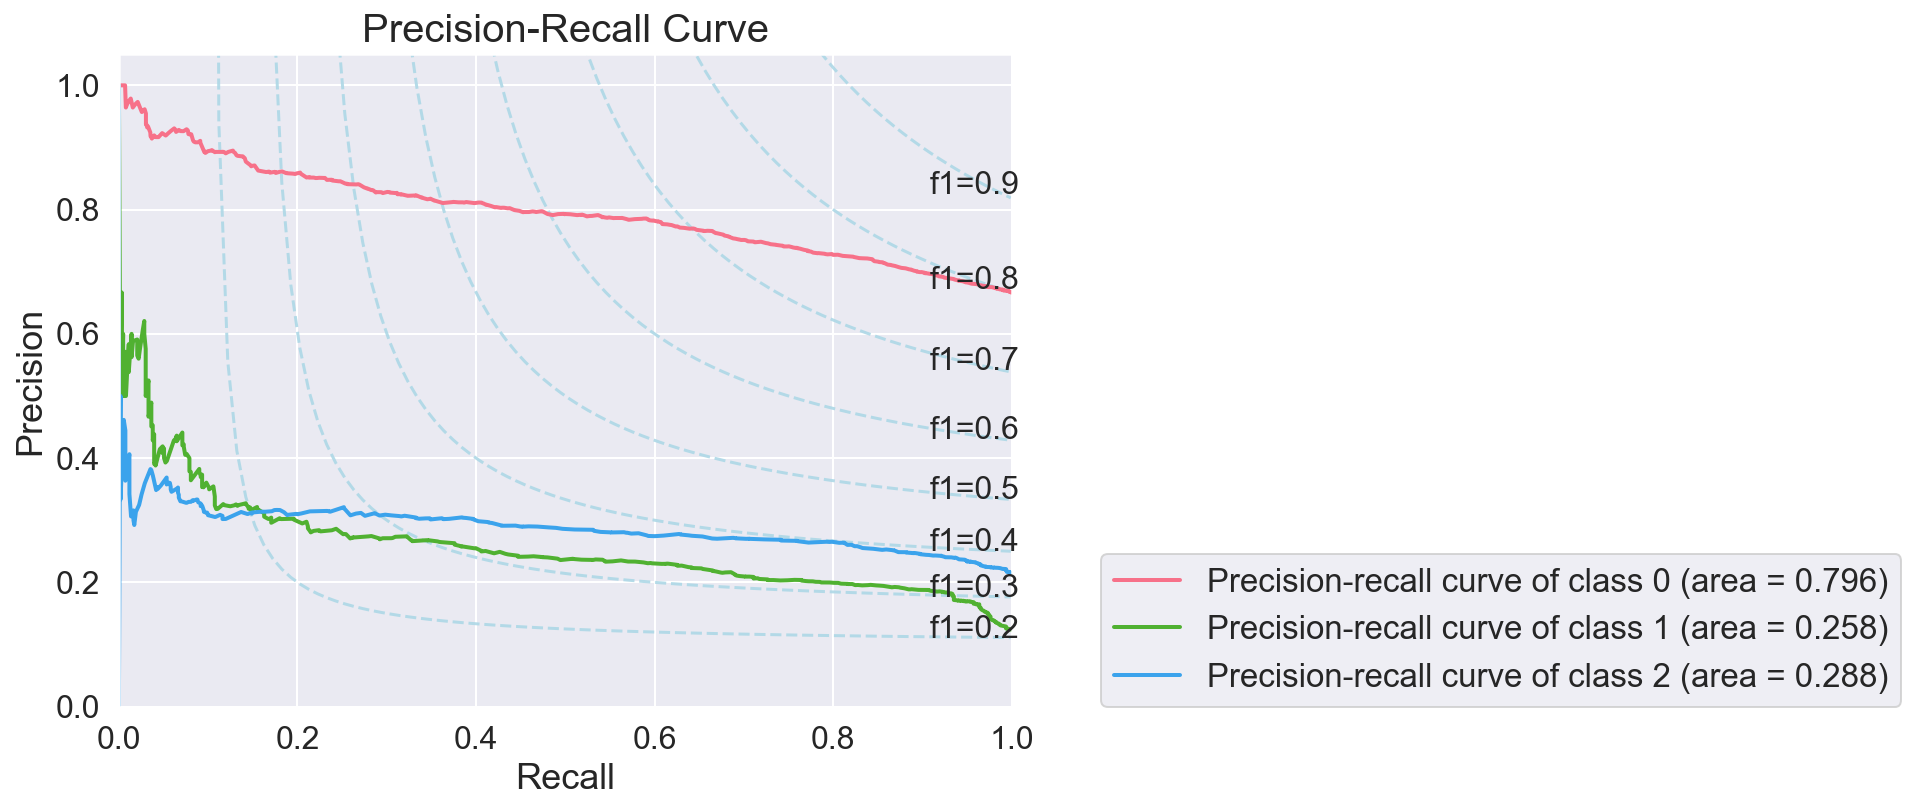

Area under precision-recall curve:
Class 0: 0.7957
Class 1: 0.2584
Class 2: 0.2878


In [56]:
#Precision-Recall curve for Model 5
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, knn_bagging.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(knn_bagging.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_5[:, i], knn_bagging.predict_proba(X_test)[:, i]), 4))

In [57]:
#Model 6 - DT Bagging
dt_bagging = BaggingClassifier(base_estimator=dt_classifier,max_samples=0.8, max_features=0.8, n_estimators=100)

dt_bagging.fit(X_train, y_train)

train_predictions_dt_bag = dt_bagging.predict(X_train)
test_predictions_dt_bag = dt_bagging.predict(X_test)
probabilities_dt_bag = dt_bagging.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_dt_bag, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_dt_bag, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_dt_bag, average='micro'))

print("Training score", dt_bagging.score(X_train, y_train))
print("Test score", dt_bagging.score(X_test, y_test))

cv_scores = cross_val_score(dt_bagging, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6368178324365873
Recall score 0.6368178324365873
F1 score 0.6368178324365873
Training score 0.8026233603997501
Test score 0.6368178324365873
CV scores [0.63968292 0.63848186 0.6392025  0.63310908 0.63695339]
Mean CV Score 0.6374859506351173


In [58]:
dt_bagging_base_estimator = dt_bagging.base_estimator_

dt_bagging_all_base_estimators = dt_bagging.estimators_

dt_bagging_estimators_features = dt_bagging.estimators_features_

samples = dt_bagging.estimators_samples_

In [59]:
np.unique(test_predictions_dt_bag)

array([0, 1, 2])

In [60]:
print(confusion_matrix(y_test, test_predictions_dt_bag, labels=[0, 1, 2]))

[[3076  124  268]
 [ 501   68   64]
 [ 878   55  170]]


In [61]:
print(classification_report(y_train, train_predictions_dt_bag, digits=4))

              precision    recall  f1-score   support

           0     0.7936    0.9748    0.8750     13868
           1     0.8583    0.4858    0.6204      2532
           2     0.8338    0.4432    0.5788      4413

    accuracy                         0.8026     20813
   macro avg     0.8286    0.6346    0.6914     20813
weighted avg     0.8100    0.8026    0.7812     20813



In [62]:
print(classification_report(y_test, test_predictions_dt_bag, digits=4))

              precision    recall  f1-score   support

           0     0.6905    0.8870    0.7765      3468
           1     0.2753    0.1074    0.1545       633
           2     0.3386    0.1541    0.2118      1103

    accuracy                         0.6368      5204
   macro avg     0.4348    0.3828    0.3810      5204
weighted avg     0.5654    0.6368    0.5811      5204



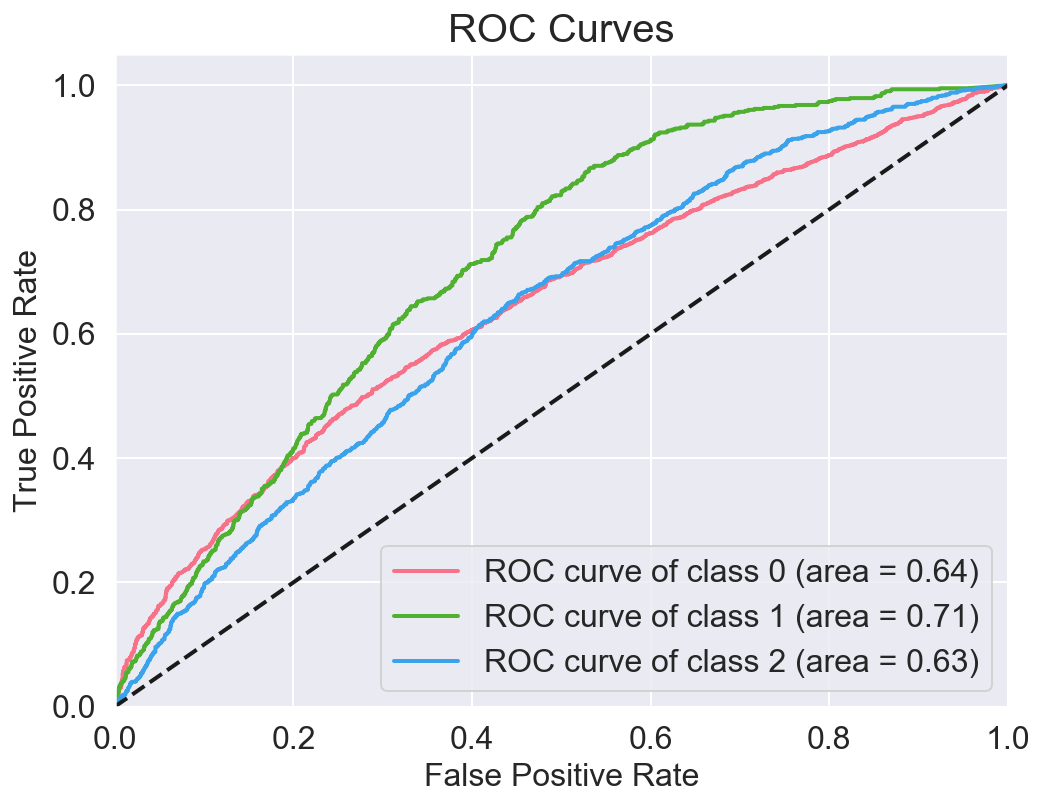

Area under ROC curve (ROC-AUC):
Class 0: 0.64
Class 1: 0.71
Class 2: 0.63


In [63]:
#ROC curve for Model 6
y_test_bin_6 = label_binarize(y_test, dt_bagging.classes_)

skplt.metrics.plot_roc(y_test, dt_bagging.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(dt_bagging.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_6[:, i], dt_bagging.predict_proba(X_test)[:, i]), 2))

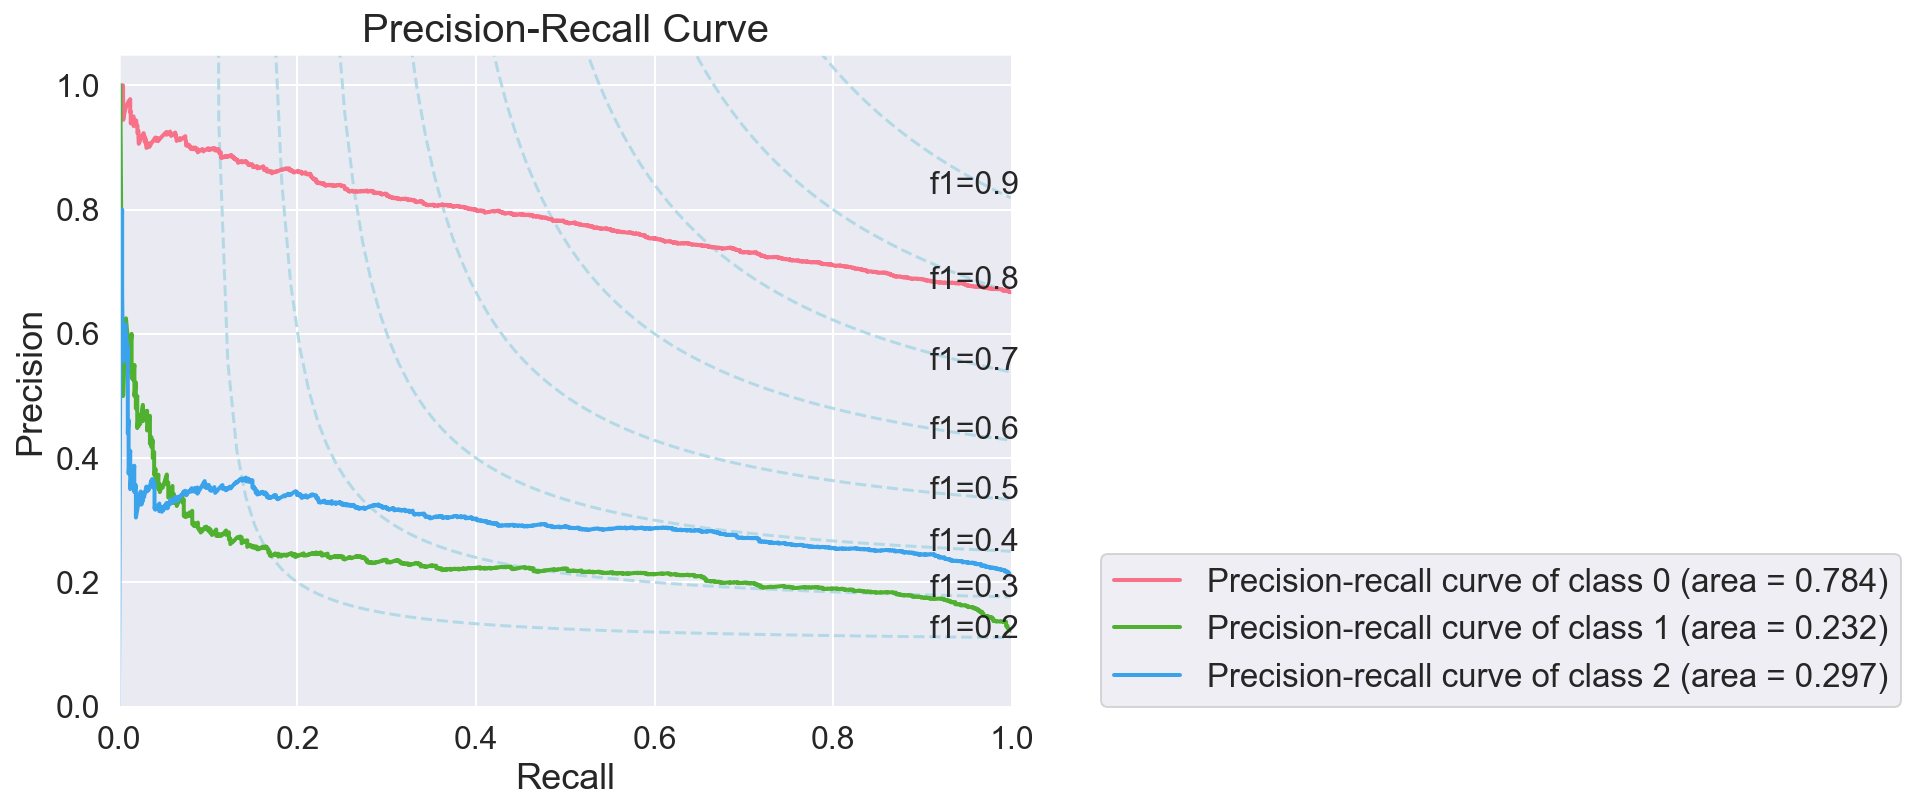

Area under precision-recall curve:
Class 0: 0.7843
Class 1: 0.2319
Class 2: 0.297


In [64]:
#Precision-Recall curve for Model 6
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, dt_bagging.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(dt_bagging.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_6[:, i], dt_bagging.predict_proba(X_test)[:, i]), 4))

KNN Bagging performed better than DT bagging did

In [65]:
#Model 7 - Random Forest
rfc=RandomForestClassifier(n_estimators=100)

rfc.fit(X_train,y_train)

train_predictions_rfc = rfc.predict(X_train)
test_predictions_rfc = rfc.predict(X_test)
probabilities_rfc = rfc.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_rfc, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_rfc, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_rfc, average='micro'))

print("Training score", rfc.score(X_train, y_train))
print("Test score", rfc.score(X_test, y_test))

cv_scores = cross_val_score(rfc, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6143351268255188
Recall score 0.6143351268255188
F1 score 0.6143351268255188
Training score 0.8186710229183684
Test score 0.6143351268255188
CV scores [0.61325967 0.62166707 0.61614221 0.60716002 0.61172513]
Mean CV Score 0.6139908184074643


In [66]:
np.unique(test_predictions_rfc)

array([0, 1, 2])

In [67]:
print(confusion_matrix(y_test, test_predictions_rfc, labels=[0, 1, 2]))

[[2889  184  395]
 [ 463   88   82]
 [ 804   79  220]]


In [68]:
print(classification_report(y_train, train_predictions_rfc, digits=4))

              precision    recall  f1-score   support

           0     0.8296    0.9474    0.8846     13868
           1     0.8008    0.5857    0.6766      2532
           2     0.7738    0.5479    0.6415      4413

    accuracy                         0.8187     20813
   macro avg     0.8014    0.6937    0.7342     20813
weighted avg     0.8143    0.8187    0.8078     20813



In [69]:
print(classification_report(y_test, test_predictions_rfc, digits=4))

              precision    recall  f1-score   support

           0     0.6951    0.8330    0.7579      3468
           1     0.2507    0.1390    0.1789       633
           2     0.3156    0.1995    0.2444      1103

    accuracy                         0.6143      5204
   macro avg     0.4205    0.3905    0.3937      5204
weighted avg     0.5606    0.6143    0.5786      5204



In [70]:
pd.DataFrame(list(zip(X_train, rfc.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)

Feature  Importance
2        Average Release Age    0.214602
1               Tracking End    0.081049
0              Year Released    0.080305
22                  Sex_Male    0.045279
21                Race_White    0.036147
19                Race_Black    0.031660
12       District_None Given    0.030637
6               District_5JD    0.028680
26  Offense Classification_5    0.025020
3               District_2JD    0.024506

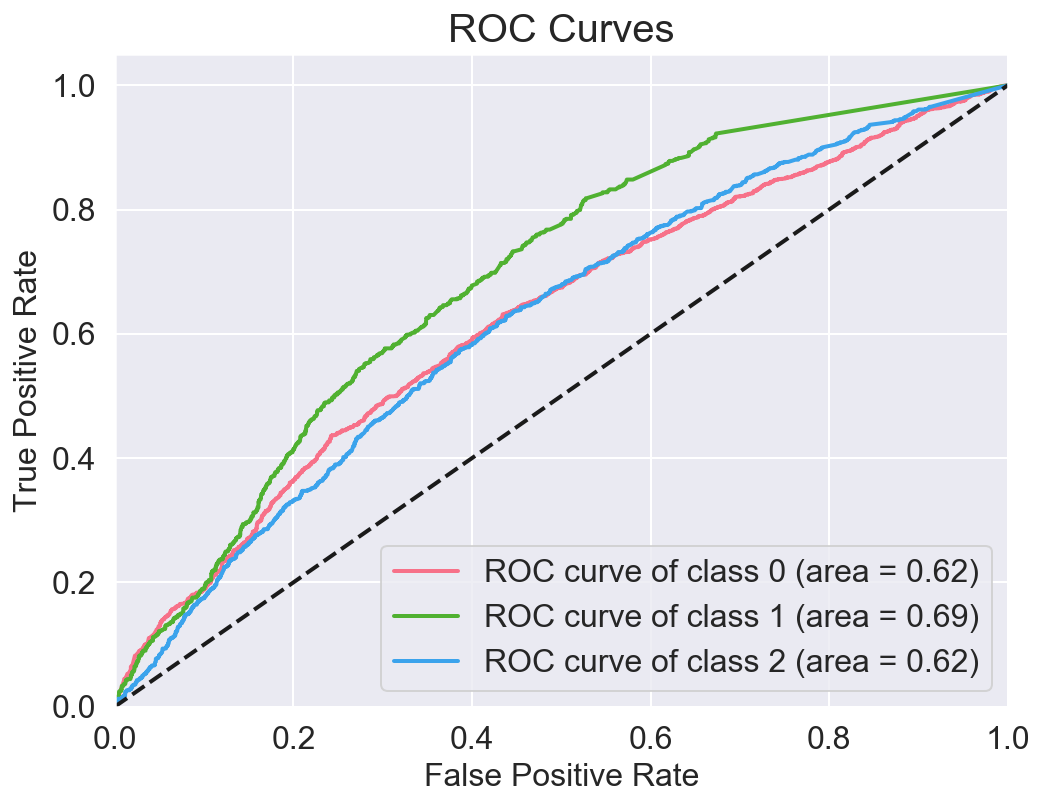

Area under ROC curve (ROC-AUC):
Class 0: 0.62
Class 1: 0.69
Class 2: 0.62


In [71]:
#ROC curve for Model 7
y_test_bin_7 = label_binarize(y_test, rfc.classes_)

skplt.metrics.plot_roc(y_test, rfc.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(rfc.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_7[:, i], rfc.predict_proba(X_test)[:, i]), 2))

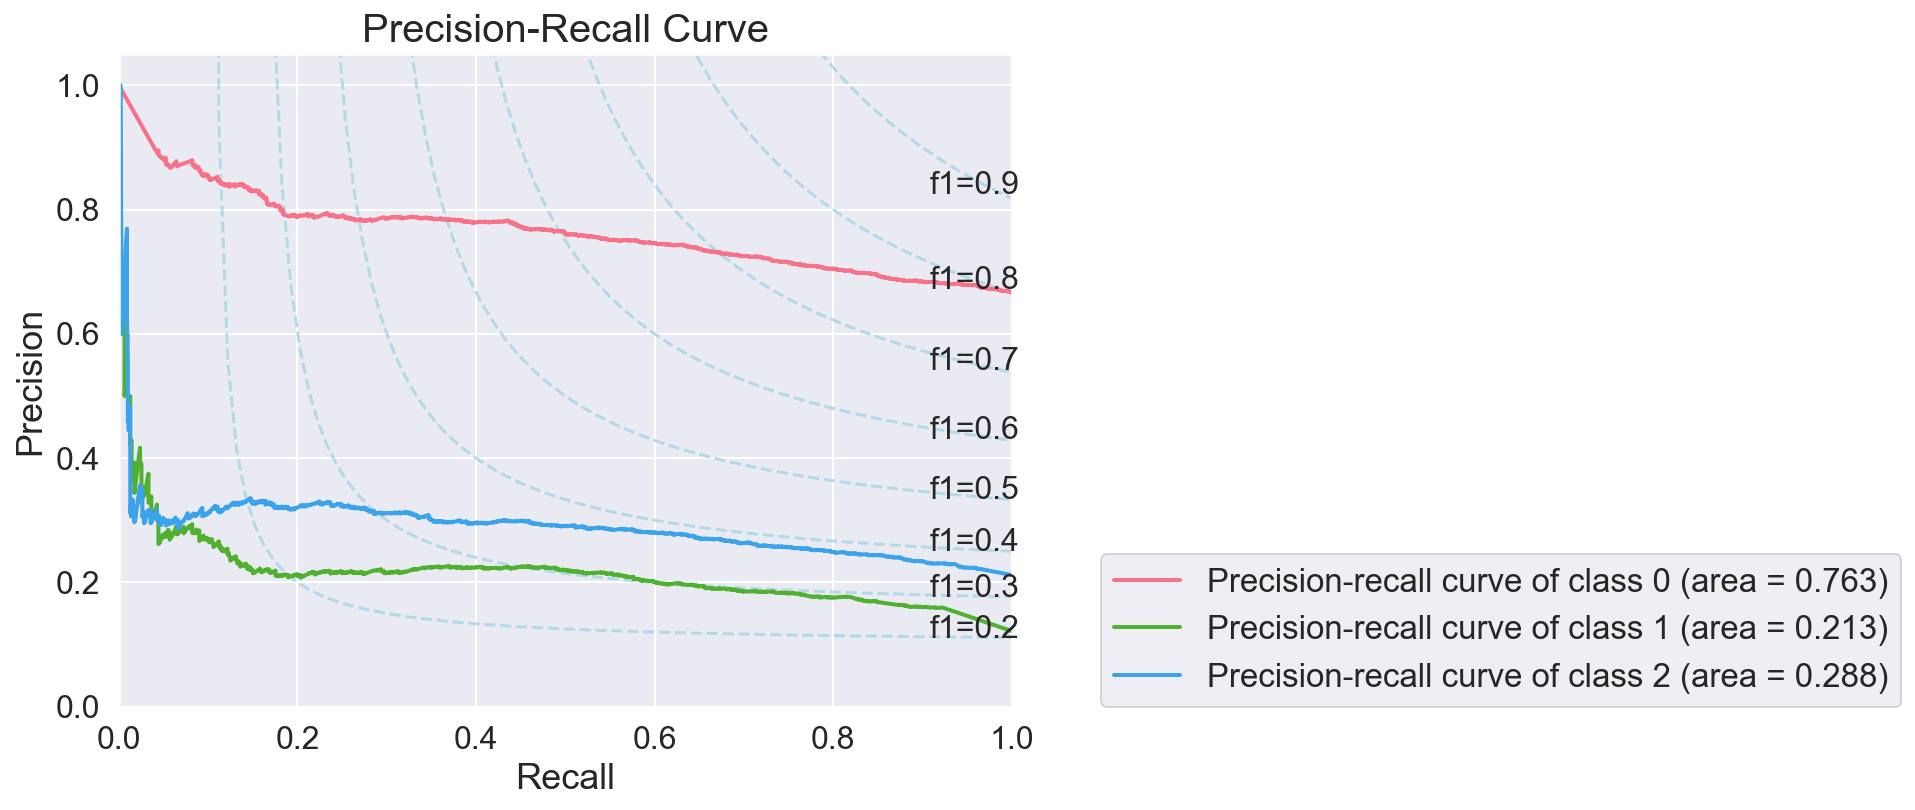

Area under precision-recall curve:
Class 0: 0.7627
Class 1: 0.2128
Class 2: 0.2881


In [72]:
#Precision-Recall curve for Model 7
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, rfc.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(rfc.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_7[:, i], rfc.predict_proba(X_test)[:, i]), 4))

In [73]:
#Model 8 - AdaBoost Classifier
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3), n_estimators=100, random_state=1)

abc.fit(X_train, y_train)

train_predictions_abc = abc.predict(X_train)
test_predictions_abc = abc.predict(X_test)
probabilities_abc = abc.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_abc, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_abc, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_abc, average='micro'))

print("Training score", abc.score(X_train, y_train))
print("Test score", abc.score(X_test, y_test))

cv_scores = cross_val_score(abc, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6535357417371253
Recall score 0.6535357417371253
F1 score 0.6535357417371253
Training score 0.6782299524335752
Test score 0.6535357417371253
CV scores [0.65865962 0.65697814 0.65337497 0.65233061 0.65353196]
Mean CV Score 0.6549750594554925


In [74]:
#AdaBoost feature importances
pd.DataFrame(list(zip(X_train, abc.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)

Feature  Importance
2        Average Release Age    0.113599
0              Year Released    0.071001
1               Tracking End    0.061771
14       Release Type_Parole    0.043195
22                  Sex_Male    0.036446
21                Race_White    0.034606
24  Offense Classification_3    0.032956
12       District_None Given    0.032300
27  Offense Classification_6    0.029407
5               District_4JD    0.028780

In [75]:
np.unique(test_predictions_abc)

array([0, 1, 2])

In [76]:
print(confusion_matrix(y_test, test_predictions_abc, labels=[0, 1, 2]))

[[3238   92  138]
 [ 552   63   18]
 [ 978   25  100]]


In [77]:
print(classification_report(y_train, train_predictions_abc, digits=4))

              precision    recall  f1-score   support

           0     0.6924    0.9518    0.8017     13868
           1     0.5408    0.1596    0.2464      2532
           2     0.5105    0.1160    0.1891      4413

    accuracy                         0.6782     20813
   macro avg     0.5812    0.4091    0.4124     20813
weighted avg     0.6354    0.6782    0.6042     20813



In [78]:
print(classification_report(y_test, test_predictions_abc, digits=4))

              precision    recall  f1-score   support

           0     0.6791    0.9337    0.7863      3468
           1     0.3500    0.0995    0.1550       633
           2     0.3906    0.0907    0.1472      1103

    accuracy                         0.6535      5204
   macro avg     0.4732    0.3746    0.3628      5204
weighted avg     0.5779    0.6535    0.5740      5204



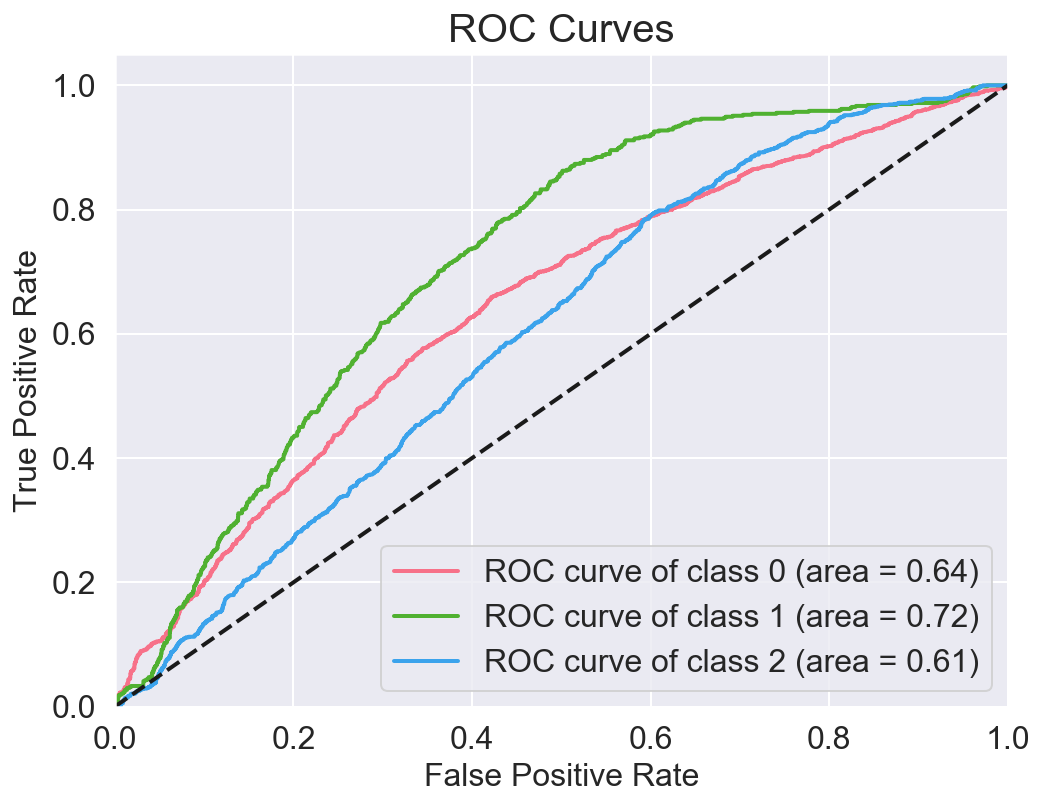

Area under ROC curve (ROC-AUC):
Class 0: 0.64
Class 1: 0.72
Class 2: 0.61


In [79]:
#ROC curve for Model 8
y_test_bin_8 = label_binarize(y_test, abc.classes_)

skplt.metrics.plot_roc(y_test, abc.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(abc.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_8[:, i], abc.predict_proba(X_test)[:, i]), 2))

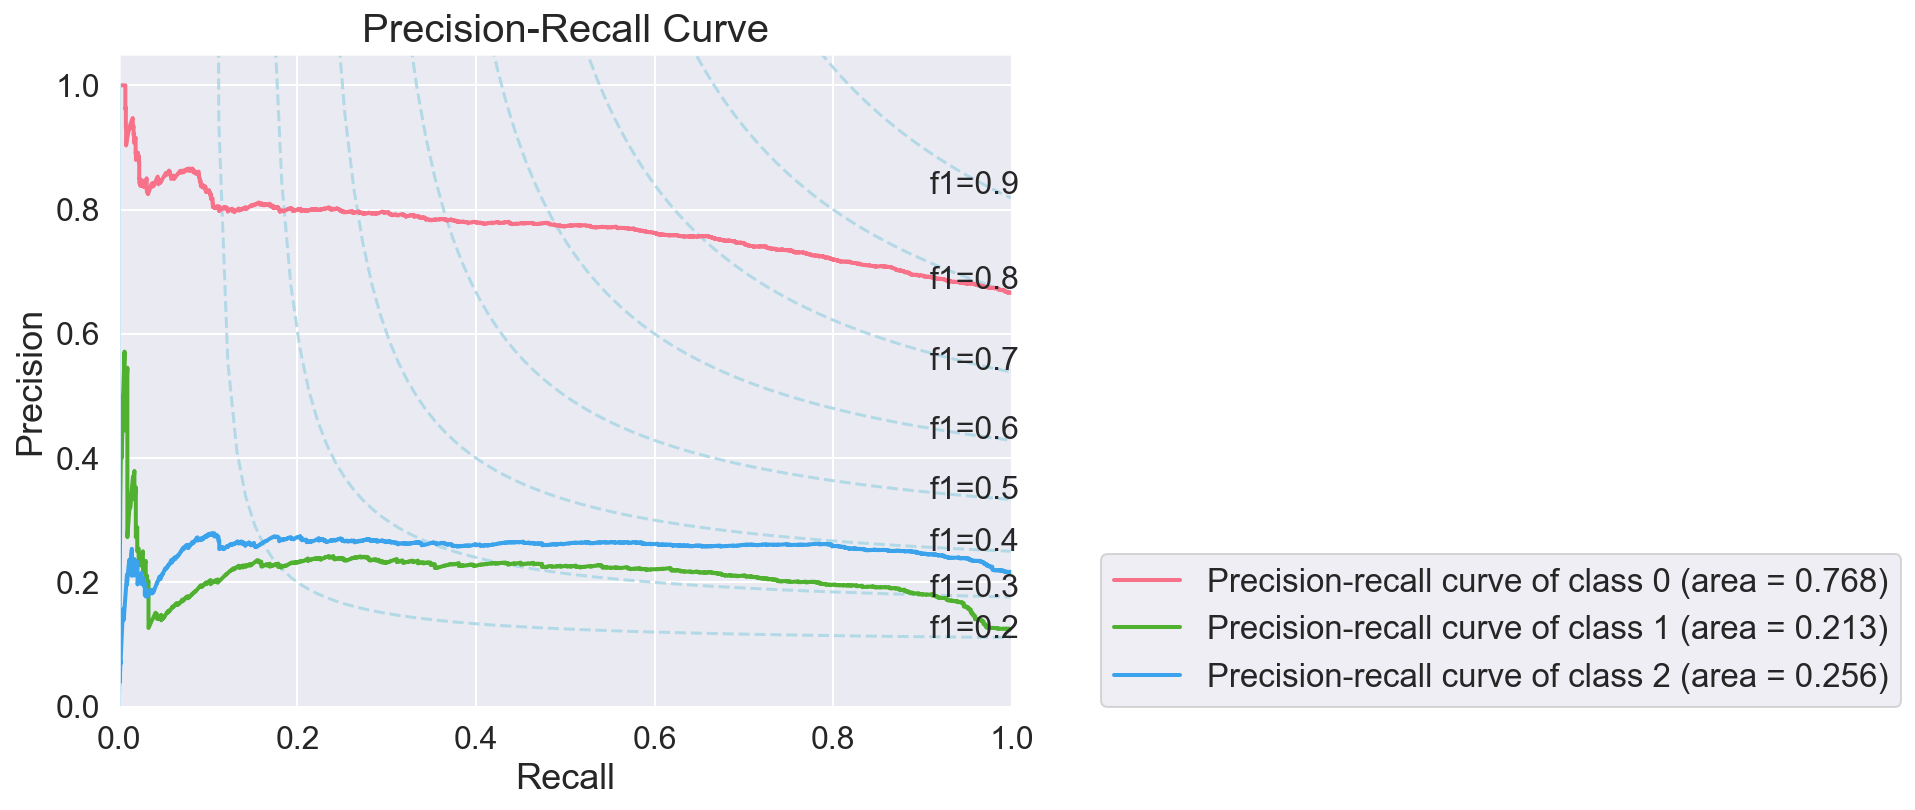

Area under precision-recall curve:
Class 0: 0.7685
Class 1: 0.2135
Class 2: 0.2555


In [80]:
#Precision-Recall curve for Model 8
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, abc.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(abc.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_8[:, i], abc.predict_proba(X_test)[:, i]), 4))

In [81]:
#Model 9 - Gradient Boost Classifier
gbc = GradientBoostingClassifier(n_estimators=10000, criterion='mse',  
                                 max_depth=3, learning_rate=0.1, random_state=1)

gbc.fit(X_train, y_train)

train_predictions_gbc = gbc.predict(X_train)
test_predictions_gbc = gbc.predict(X_test)
probabilities_gbc = gbc.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_gbc, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_gbc, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_gbc, average='micro'))

print("Training score", gbc.score(X_train, y_train))
print("Test score", gbc.score(X_test, y_test))

cv_scores = cross_val_score(gbc, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6464258262874711
Recall score 0.6464258262874711
F1 score 0.6464258262874711
Training score 0.7310334886849565
Test score 0.6464258262874711
CV scores [0.64712947 0.63535912 0.6370406  0.63791446 0.63791446]
Mean CV Score 0.6390716228166419


In [82]:
#Gradient Boost Feature Importances
pd.DataFrame(list(zip(X_train, gbc.feature_importances_)), 
             columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False).head(10)


Feature  Importance
12       District_None Given    0.138346
2        Average Release Age    0.125580
1               Tracking End    0.077268
0              Year Released    0.072787
22                  Sex_Male    0.034942
6               District_5JD    0.031398
14       Release Type_Parole    0.030503
24  Offense Classification_3    0.024424
16    Ethnicity_Non-Hispanic    0.023995
21                Race_White    0.021738

In [83]:
np.unique(test_predictions_gbc)

array([0, 1, 2])

In [84]:
print(confusion_matrix(y_test, test_predictions_gbc, labels=[0, 1, 2]))

[[3148  140  180]
 [ 503   79   51]
 [ 917   49  137]]


In [85]:
print(classification_report(y_train, train_predictions_gbc, digits=4))

              precision    recall  f1-score   support

           0     0.7344    0.9606    0.8324     13868
           1     0.7189    0.3171    0.4401      2532
           2     0.7005    0.2470    0.3652      4413

    accuracy                         0.7310     20813
   macro avg     0.7179    0.5083    0.5459     20813
weighted avg     0.7253    0.7310    0.6856     20813



In [86]:
print(classification_report(y_test, test_predictions_gbc, digits=4))

              precision    recall  f1-score   support

           0     0.6891    0.9077    0.7835      3468
           1     0.2948    0.1248    0.1754       633
           2     0.3723    0.1242    0.1863      1103

    accuracy                         0.6464      5204
   macro avg     0.4521    0.3856    0.3817      5204
weighted avg     0.5740    0.6464    0.5829      5204



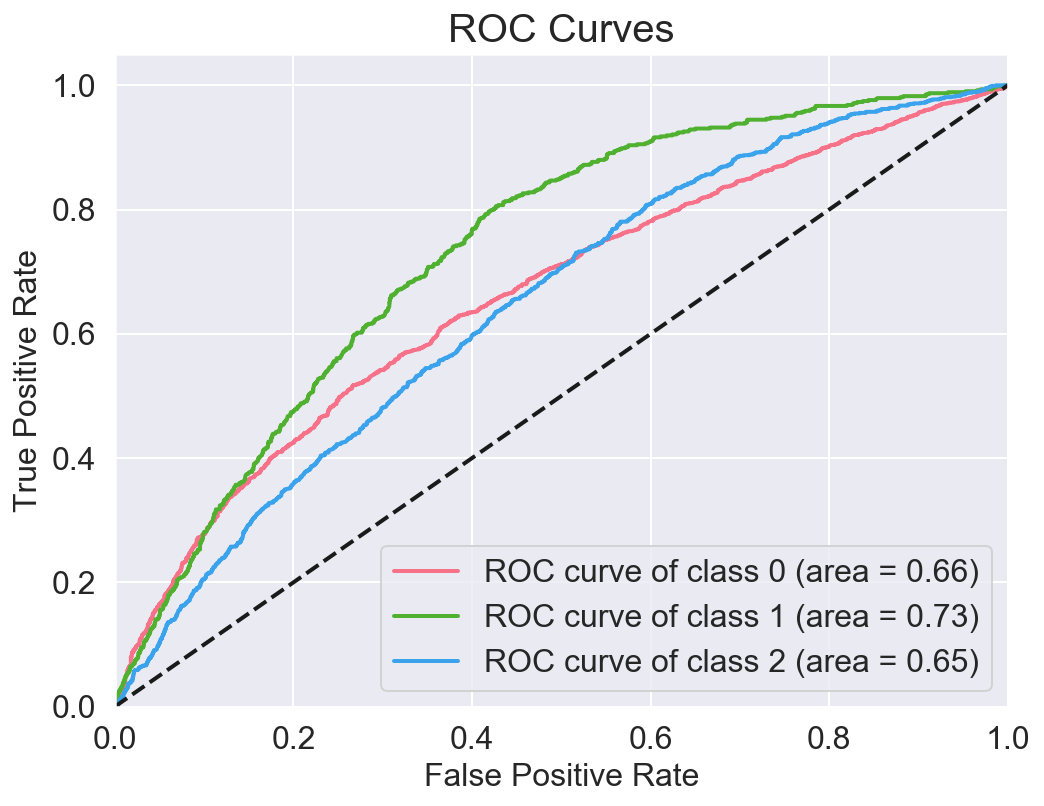

Area under ROC curve (ROC-AUC):
Class 0: 0.66
Class 1: 0.73
Class 2: 0.65


In [87]:
#ROC curve for Model 9
y_test_bin_9 = label_binarize(y_test, gbc.classes_)

skplt.metrics.plot_roc(y_test, gbc.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(gbc.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_9[:, i], gbc.predict_proba(X_test)[:, i]), 2))

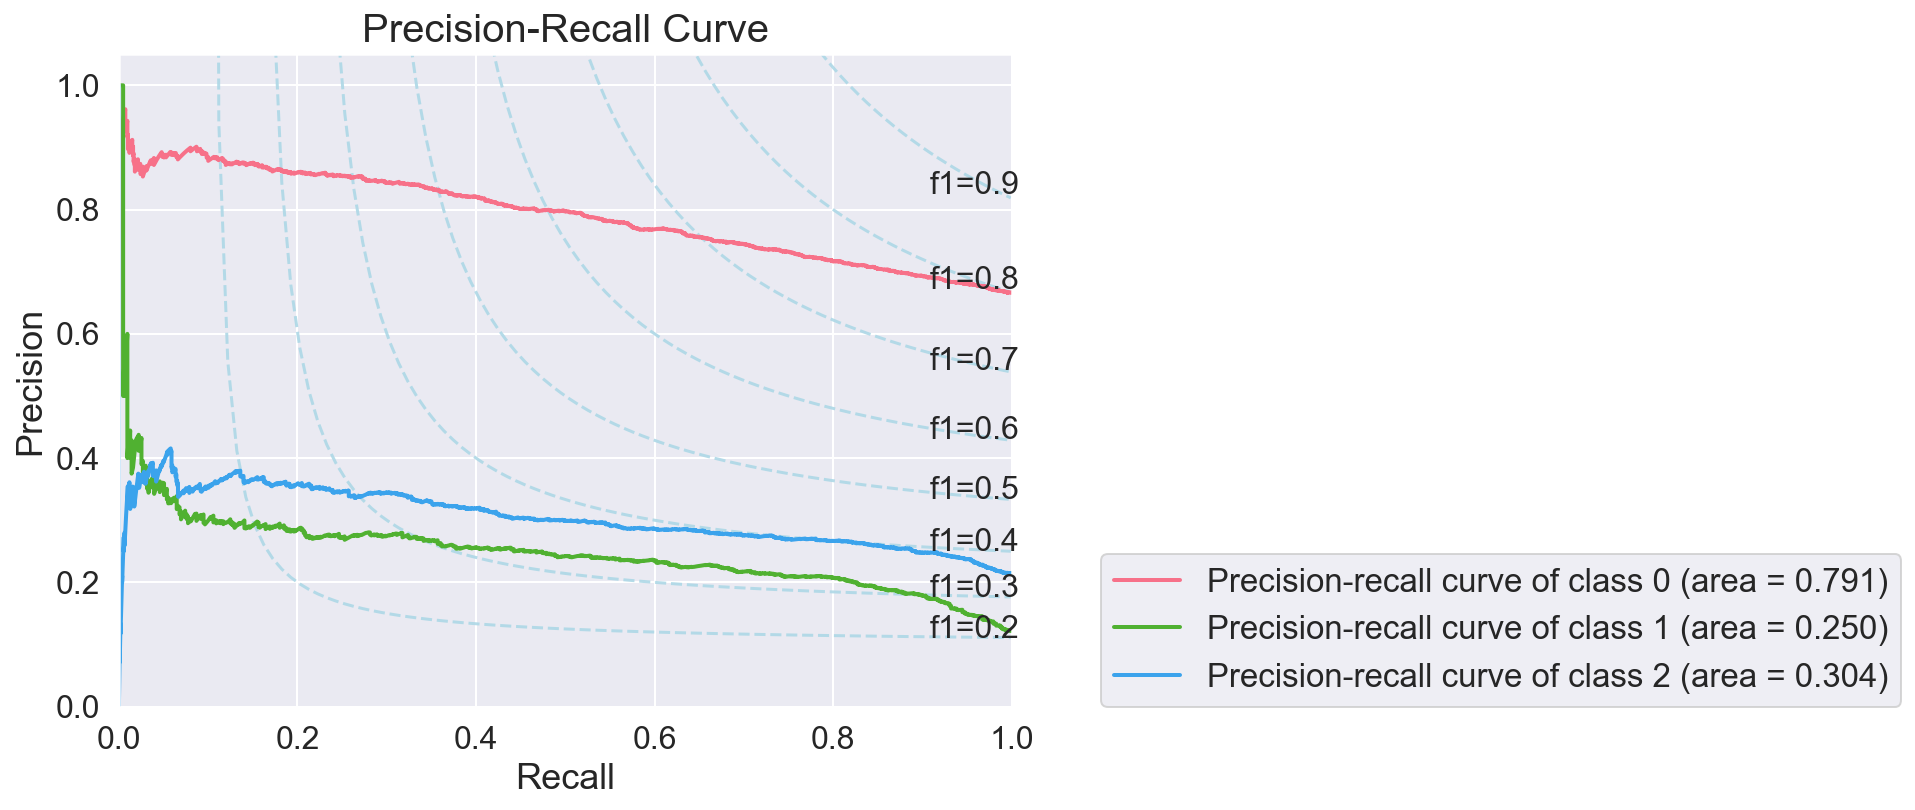

Area under precision-recall curve:
Class 0: 0.7905
Class 1: 0.2497
Class 2: 0.3041


In [88]:
#Precision-Recall curve for Model 9
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, gbc.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(gbc.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_9[:, i], gbc.predict_proba(X_test)[:, i]), 4))

In [89]:
#Model 10 - Naive Bayes BernoulliNB
nb_B = naive_bayes.BernoulliNB(binarize=None)

nb_B.fit(X_train, y_train)

train_predictions_nb_B = nb_B.predict(X_train)
test_predictions_nb_B = nb_B.predict(X_test)
probabilities_nb_B = nb_B.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_nb_B, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_nb_B, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_nb_B, average='micro'))

print('Training score', nb_B.score(X_train, y_train))
print('Testing score', nb_B.score(X_test, y_test))

cv_scores = cross_val_score(nb_B, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6664104534973098
Recall score 0.6664104534973098
F1 score 0.6664104534973098
Training score 0.6663143227790324
Testing score 0.6664104534973098
CV scores [0.66634638 0.66634638 0.66634638 0.66626622 0.66626622]
Mean CV Score 0.6663143181569219


In [90]:
np.unique(test_predictions_nb_B)

array([0])

In [91]:
print(confusion_matrix(y_test, test_predictions_nb_B, labels=[0, 1, 2]))

[[3468    0    0]
 [ 633    0    0]
 [1103    0    0]]


In [92]:
print(classification_report(y_train, train_predictions_nb_B, digits=4))

              precision    recall  f1-score   support

           0     0.6663    1.0000    0.7997     13868
           1     0.0000    0.0000    0.0000      2532
           2     0.0000    0.0000    0.0000      4413

    accuracy                         0.6663     20813
   macro avg     0.2221    0.3333    0.2666     20813
weighted avg     0.4440    0.6663    0.5329     20813



In [93]:
print(classification_report(y_test, test_predictions_nb_B, digits=4))

              precision    recall  f1-score   support

           0     0.6664    1.0000    0.7998      3468
           1     0.0000    0.0000    0.0000       633
           2     0.0000    0.0000    0.0000      1103

    accuracy                         0.6664      5204
   macro avg     0.2221    0.3333    0.2666      5204
weighted avg     0.4441    0.6664    0.5330      5204



In [94]:
#Model 11 - Multinomial Naive Bayes - standardise with MinMaxScaler- see other notebook
#Precision score 0.6550730207532667
#Recall score 0.6550730207532667
#F1 score 0.6550730207532667
#Training score 0.6547830682746361
#Testing score 0.6550730207532667
#CV scores [0.65313476 0.65697814 0.65505645 0.65209034 0.6516098 ]
#Mean CV Score 0.6537738986377211

In [95]:
#np.unique(test_predictions_nb_M)
#array([0, 1, 2])

In [96]:
#Bayes Gaussian doesn't apply here
#power = PowerTransformer()
#X_trainp = power.fit_transform(X_train)
#X_testp = power.transform(X_test)

#nb_G = naive_bayes.GaussianNB()

#nb_G.fit(X_trainp, y_train)

#trainp_predictions_nb_G = nb_G.predict(X_trainp)
#test_predictions_nb_G = nb_G.predict(X_testp)
#probabilities_nb_G = nb_G.predict_proba(X_testp)

#print('Precision score', precision_score(y_test, test_predictions_nb_G, average='micro'))
#print('Recall score', (recall_score(y_test, test_predictions_nb_G, average='micro')))
#print('F1 score', f1_score(y_test, test_predictions_nb_G, average='micro'))

#print('Training score', nb_G.score(X_trainp, y_train))
#print('Testing score', nb_G.score(X_testp, y_test))

#cv_scores = cross_val_score(nb_G, X_trainp, y_train, cv=5)
#print('CV scores', cv_scores)
#print('Mean CV Score', np.mean(cv_scores))

In [97]:
#Model 12 - SVC linear
svc_lin = SVC(kernel='linear', gamma='scale')

svc_lin.fit(X_train, y_train)

train_predictions_svc_lin = svc_lin.predict(X_train)
test_predictions_svc_lin = svc_lin.predict(X_test)

print('Precision score', precision_score(y_test, test_predictions_svc_lin, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_svc_lin, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_svc_lin, average='micro'))

print('Training score', svc_lin.score(X_train, y_train))
print('Testing score', svc_lin.score(X_test, y_test))

cv_scores = cross_val_score(svc_lin, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6644888547271329
Recall score 0.6644888547271329
F1 score 0.6644888547271329
Training score 0.6671311199730937
Testing score 0.6644888547271329
CV scores [0.66634638 0.66322364 0.66634638 0.66290245 0.66626622]
Mean CV Score 0.6650170150693687


In [98]:
np.unique(test_predictions_svc_lin)

array([0, 2])

In [99]:
print(confusion_matrix(y_test, test_predictions_svc_lin, labels=[0, 1, 2]))

[[3404    0   64]
 [ 632    0    1]
 [1049    0   54]]


In [100]:
print(classification_report(y_train, train_predictions_svc_lin, digits=4))

              precision    recall  f1-score   support

           0     0.6706    0.9837    0.7975     13868
           1     0.0000    0.0000    0.0000      2532
           2     0.5159    0.0551    0.0995      4413

    accuracy                         0.6671     20813
   macro avg     0.3955    0.3463    0.2990     20813
weighted avg     0.5562    0.6671    0.5525     20813



In [101]:
print(classification_report(y_test, test_predictions_svc_lin, digits=4))

              precision    recall  f1-score   support

           0     0.6694    0.9815    0.7960      3468
           1     0.0000    0.0000    0.0000       633
           2     0.4538    0.0490    0.0884      1103

    accuracy                         0.6645      5204
   macro avg     0.3744    0.3435    0.2948      5204
weighted avg     0.5423    0.6645    0.5492      5204



In [102]:
#Model 13 - SVC poly
svc_poly = SVC(kernel='poly', gamma='scale')

svc_poly.fit(X_train, y_train)

train_predictions_svc_poly = svc_poly.predict(X_train)
test_predictions_svc_poly = svc_poly.predict(X_test)

print('Precision score', precision_score(y_test, test_predictions_svc_poly, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_svc_poly, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_svc_poly, average='micro'))

print('Training score', svc_poly.score(X_train, y_train))
print('Testing score', svc_poly.score(X_test, y_test))

cv_scores = cross_val_score(svc_poly, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6619907763259032
Recall score 0.6619907763259032
F1 score 0.6619907763259032
Training score 0.6823619852976505
Testing score 0.6619907763259032
CV scores [0.66562575 0.66562575 0.66514533 0.66530514 0.66626622]
Mean CV Score 0.6655936378265637


In [103]:
np.unique(test_predictions_svc_poly)

array([0, 1, 2])

In [104]:
print(confusion_matrix(y_test, test_predictions_svc_poly, labels=[0, 1, 2]))

[[3401   31   36]
 [ 603   25    5]
 [1075    9   19]]


In [105]:
print(classification_report(y_train, train_predictions_svc_poly, digits=4))

              precision    recall  f1-score   support

           0     0.6801    0.9927    0.8072     13868
           1     0.7649    0.0964    0.1712      2532
           2     0.7610    0.0433    0.0819      4413

    accuracy                         0.6824     20813
   macro avg     0.7353    0.3775    0.3534     20813
weighted avg     0.7076    0.6824    0.5760     20813



In [106]:
print(classification_report(y_test, test_predictions_svc_poly, digits=4))

              precision    recall  f1-score   support

           0     0.6696    0.9807    0.7958      3468
           1     0.3846    0.0395    0.0716       633
           2     0.3167    0.0172    0.0327      1103

    accuracy                         0.6620      5204
   macro avg     0.4570    0.3458    0.3000      5204
weighted avg     0.5601    0.6620    0.5460      5204



In [108]:
#Model 14 - SVC rbf
svc_rbf = SVC(kernel='rbf', gamma='scale')

svc_rbf.fit(X_train, y_train)

train_predictions_svc_rbf = svc_rbf.predict(X_train)
test_predictions_svc_rbf = svc_rbf.predict(X_test)

print('Precision score', precision_score(y_test, test_predictions_svc_rbf, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_svc_rbf, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_svc_rbf, average='micro'))

print('Training score', svc_rbf.score(X_train, y_train))
print('Testing score', svc_rbf.score(X_test, y_test))

cv_scores = cross_val_score(svc_rbf, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6664104534973098
Recall score 0.6664104534973098
F1 score 0.6664104534973098
Training score 0.67352135684428
Testing score 0.6664104534973098
CV scores [0.6665866  0.6687485  0.66826808 0.66650649 0.66674676]
Mean CV Score 0.6673712828846329


In [109]:
np.unique(test_predictions_svc_rbf)

array([0, 1, 2])

In [110]:
print(confusion_matrix(y_test, test_predictions_svc_rbf, labels=[0, 1, 2]))

[[3439   15   14]
 [ 610   20    3]
 [1092    2    9]]


In [111]:
print(classification_report(y_train, train_predictions_svc_rbf, digits=4))

              precision    recall  f1-score   support

           0     0.6729    0.9949    0.8028     13868
           1     0.6818    0.0592    0.1090      2532
           2     0.7889    0.0161    0.0315      4413

    accuracy                         0.6735     20813
   macro avg     0.7145    0.3567    0.3145     20813
weighted avg     0.6986    0.6735    0.5549     20813



In [112]:
print(classification_report(y_test, test_predictions_svc_rbf, digits=4))

              precision    recall  f1-score   support

           0     0.6689    0.9916    0.7989      3468
           1     0.5405    0.0316    0.0597       633
           2     0.3462    0.0082    0.0159      1103

    accuracy                         0.6664      5204
   macro avg     0.5185    0.3438    0.2915      5204
weighted avg     0.5849    0.6664    0.5431      5204



In [113]:
#Model 15 - SVC sigmoid
svc_sig = SVC(kernel='sigmoid', gamma='scale')

svc_sig.fit(X_train, y_train)

train_predictions_svc_sig = svc_sig.predict(X_train)
test_predictions_svc_sig = svc_sig.predict(X_test)

print('Precision score', precision_score(y_test, test_predictions_svc_sig, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_svc_sig, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_svc_sig, average='micro'))

print('Training score', svc_sig.score(X_train, y_train))
print('Testing score', svc_sig.score(X_test, y_test))

cv_scores = cross_val_score(svc_sig, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.5906994619523444
Recall score 0.5906994619523444
F1 score 0.5906994619523444
Training score 0.5821361648969394
Testing score 0.5906994619523444
CV scores [0.61157819 0.6118184  0.60629354 0.59226333 0.6081211 ]
Mean CV Score 0.6060149115748529


In [114]:
np.unique(test_predictions_svc_rbf)

array([0, 1, 2])

In [115]:
print(confusion_matrix(y_test, test_predictions_svc_rbf, labels=[0, 1, 2]))

[[3439   15   14]
 [ 610   20    3]
 [1092    2    9]]


In [116]:
print(classification_report(y_train, train_predictions_svc_rbf, digits=4))

              precision    recall  f1-score   support

           0     0.6729    0.9949    0.8028     13868
           1     0.6818    0.0592    0.1090      2532
           2     0.7889    0.0161    0.0315      4413

    accuracy                         0.6735     20813
   macro avg     0.7145    0.3567    0.3145     20813
weighted avg     0.6986    0.6735    0.5549     20813



In [117]:
print(classification_report(y_test, test_predictions_svc_rbf, digits=4))

              precision    recall  f1-score   support

           0     0.6689    0.9916    0.7989      3468
           1     0.5405    0.0316    0.0597       633
           2     0.3462    0.0082    0.0159      1103

    accuracy                         0.6664      5204
   macro avg     0.5185    0.3438    0.2915      5204
weighted avg     0.5849    0.6664    0.5431      5204



In [118]:
#Model 16 - MLP Classifier LBFGS
nnet_lbfgs = MLPClassifier(solver='lbfgs',
                    alpha=10**(-10),
                    hidden_layer_sizes=(10, 10, 10, 10, 10),
                    activation='relu',
                    random_state=1,
                    batch_size='auto')

nnet_lbfgs.fit(X_train, y_train)

train_predictions_nnet_lbfgs = nnet_lbfgs.predict(X_train)
test_predictions_nnet_lbfgs = nnet_lbfgs.predict(X_test)
probabilities_nnet_lbfgs = nnet_lbfgs.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_nnet_lbfgs, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_nnet_lbfgs, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_nnet_lbfgs, average='micro'))

print('Training score', nnet_lbfgs.score(X_train, y_train))
print('Testing score', nnet_lbfgs.score(X_test, y_test))

cv_scores = cross_val_score(nnet_lbfgs, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6541122213681784
Recall score 0.6541122213681784
F1 score 0.6541122213681784
Training score 0.6794311247777831
Testing score 0.6541122213681784
CV scores [0.66514533 0.6581792  0.66202258 0.66049976 0.66386353]
Mean CV Score 0.6619420784668211


In [119]:
np.unique(test_predictions_nnet_lbfgs)

array([0, 1, 2])

In [120]:
print(confusion_matrix(y_test, test_predictions_nnet_lbfgs, labels=[0, 1, 2]))

[[3275   90  103]
 [ 550   62   21]
 [ 994   42   67]]


In [121]:
print(classification_report(y_train, train_predictions_nnet_lbfgs, digits=4))

              precision    recall  f1-score   support

           0     0.6917    0.9598    0.8040     13868
           1     0.4948    0.1497    0.2298      2532
           2     0.5616    0.1022    0.1729      4413

    accuracy                         0.6794     20813
   macro avg     0.5827    0.4039    0.4023     20813
weighted avg     0.6402    0.6794    0.6003     20813



In [122]:
print(classification_report(y_test, test_predictions_nnet_lbfgs, digits=4))

              precision    recall  f1-score   support

           0     0.6796    0.9443    0.7904      3468
           1     0.3196    0.0979    0.1499       633
           2     0.3508    0.0607    0.1036      1103

    accuracy                         0.6541      5204
   macro avg     0.4500    0.3677    0.3480      5204
weighted avg     0.5661    0.6541    0.5669      5204



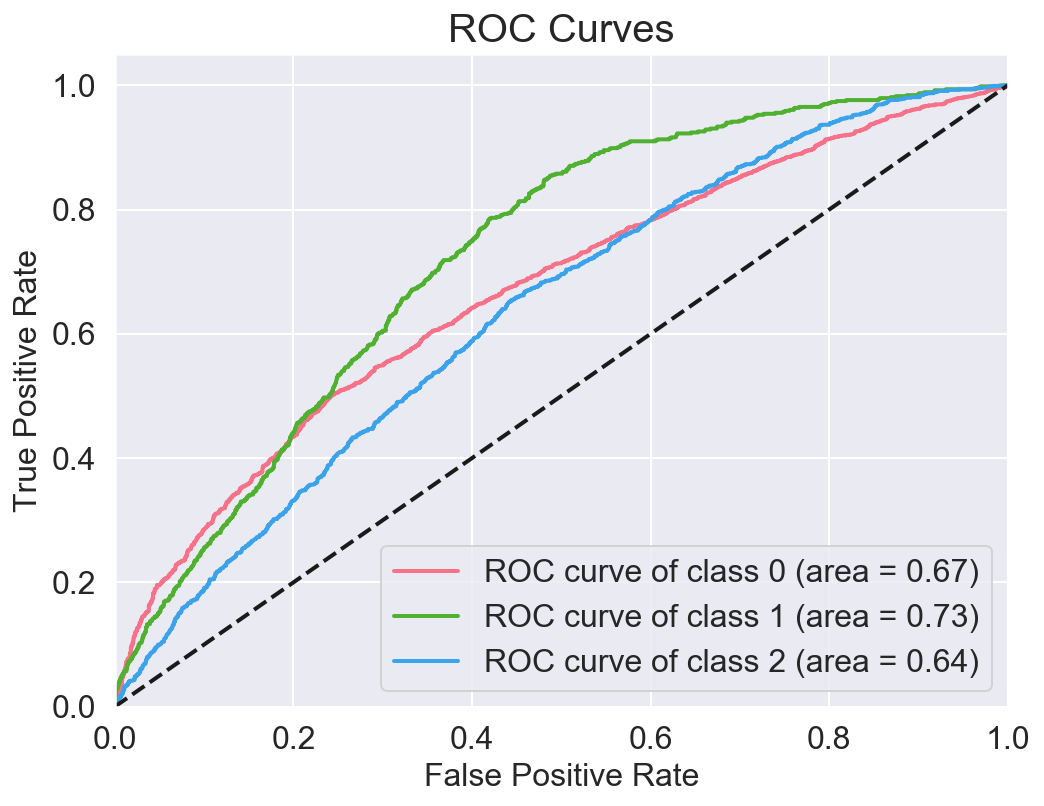

Area under ROC curve (ROC-AUC):
Class 0: 0.67
Class 1: 0.73
Class 2: 0.64


In [123]:
y_test_bin_16 = label_binarize(y_test, nnet_lbfgs.classes_)

skplt.metrics.plot_roc(y_test, nnet_lbfgs.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(nnet_lbfgs.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_16[:, i], nnet_lbfgs.predict_proba(X_test)[:, i]), 2))

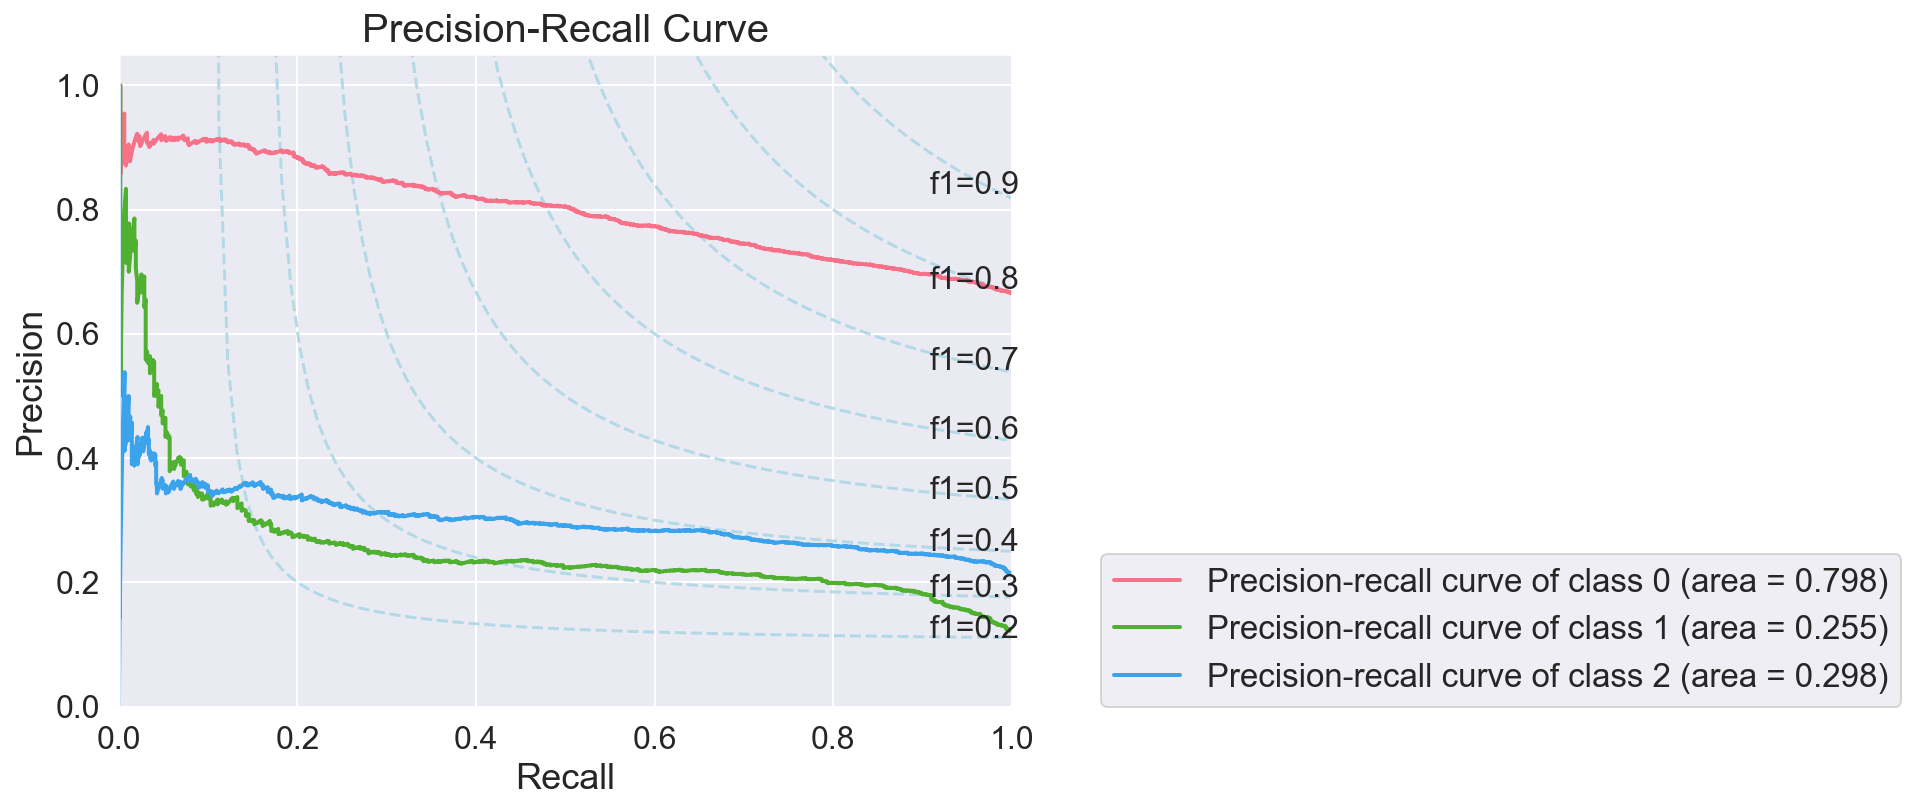

Area under precision-recall curve:
Class 0: 0.7983
Class 1: 0.255
Class 2: 0.298


In [124]:
#Precision-Recall curve for Model 16
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, nnet_lbfgs.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(nnet_lbfgs.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_16[:, i], nnet_lbfgs.predict_proba(X_test)[:, i]), 4))

In [125]:
#Model 17 - MLP Classifier Adam
nnet_adam = MLPClassifier(solver='adam',
                    alpha=10**(0),
                    hidden_layer_sizes=(10, 10, 10, 10, 10),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=500)

nnet_adam.fit(X_train, y_train)

train_predictions_nnet_adam = nnet_adam.predict(X_train)
test_predictions_nnet_adam = nnet_adam.predict(X_test)
probabilities_nnet_adam = nnet_adam.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_nnet_adam, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_nnet_adam, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_nnet_adam, average='micro'))

print('Training score', nnet_adam.score(X_train, y_train))
print('Testing score', nnet_adam.score(X_test, y_test))

cv_scores = cross_val_score(nnet_adam, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6664104534973098
Recall score 0.6664104534973098
F1 score 0.6664104534973098
Training score 0.6663143227790324
Testing score 0.6664104534973098
CV scores [0.66634638 0.66634638 0.66634638 0.66626622 0.66626622]
Mean CV Score 0.6663143181569219


In [126]:
np.unique(test_predictions_nnet_adam)

array([0])

In [127]:
print(confusion_matrix(y_test, test_predictions_nnet_adam, labels=[0, 1, 2]))

[[3468    0    0]
 [ 633    0    0]
 [1103    0    0]]


In [128]:
print(classification_report(y_train, train_predictions_nnet_adam, digits=4))

              precision    recall  f1-score   support

           0     0.6663    1.0000    0.7997     13868
           1     0.0000    0.0000    0.0000      2532
           2     0.0000    0.0000    0.0000      4413

    accuracy                         0.6663     20813
   macro avg     0.2221    0.3333    0.2666     20813
weighted avg     0.4440    0.6663    0.5329     20813



In [129]:
print(classification_report(y_test, test_predictions_nnet_adam, digits=4))

              precision    recall  f1-score   support

           0     0.6664    1.0000    0.7998      3468
           1     0.0000    0.0000    0.0000       633
           2     0.0000    0.0000    0.0000      1103

    accuracy                         0.6664      5204
   macro avg     0.2221    0.3333    0.2666      5204
weighted avg     0.4441    0.6664    0.5330      5204



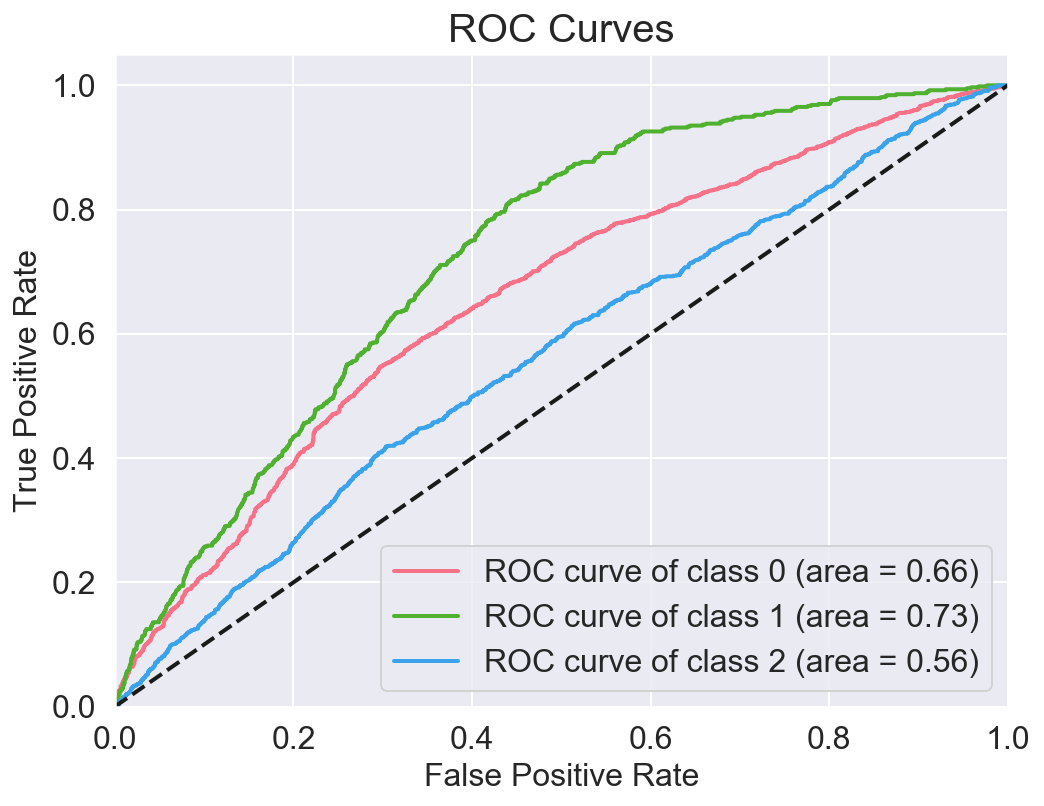

Area under ROC curve (ROC-AUC):
Class 0: 0.66
Class 1: 0.73
Class 2: 0.56


In [130]:
y_test_bin_17 = label_binarize(y_test, nnet_adam.classes_)

skplt.metrics.plot_roc(y_test, nnet_adam.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(nnet_adam.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_17[:, i], nnet_adam.predict_proba(X_test)[:, i]), 2))

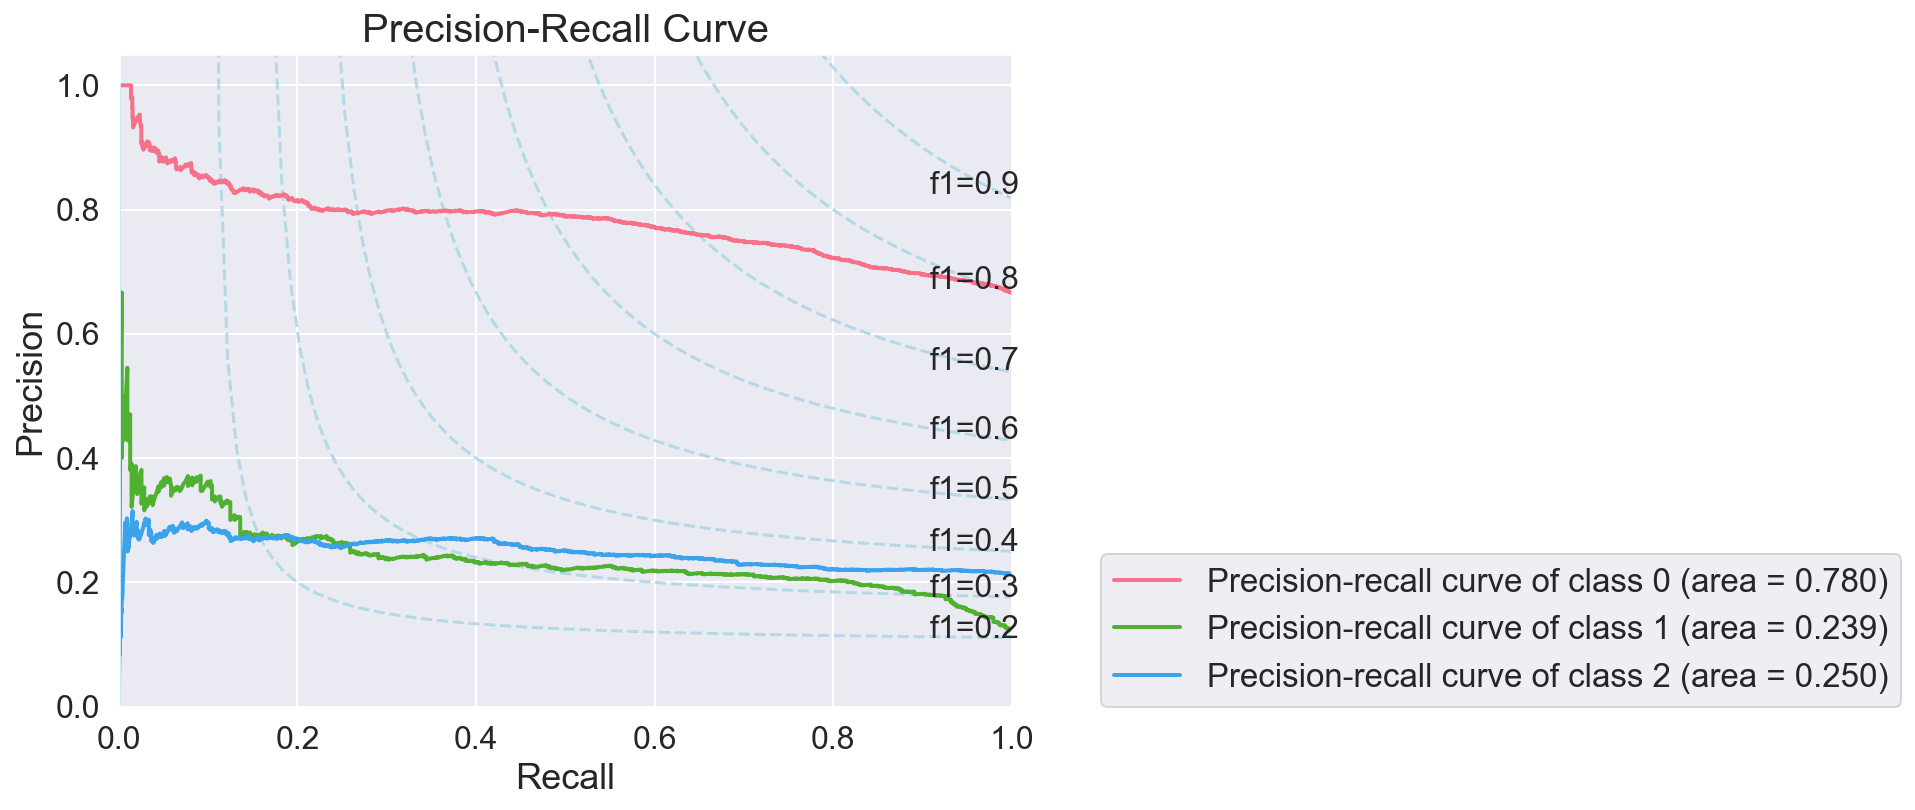

Area under precision-recall curve:
Class 0: 0.7798
Class 1: 0.2394
Class 2: 0.2496


In [131]:
#Precision-Recall curve for Model 17
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, nnet_adam.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Area under precision-recall curve:')
for i, class_ in enumerate(nnet_adam.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_17[:, i], nnet_adam.predict_proba(X_test)[:, i]), 4))

In [16]:
# Model 18 - MLP Classifier sgd
nnet_sgd = MLPClassifier(solver='sgd',
                    alpha=10**(0),
                    hidden_layer_sizes=(10, 10, 10, 10, 10),
                    activation='relu',
                    random_state=42,
                    batch_size=50,
                    max_iter=500)

nnet_sgd.fit(X_train, y_train)

train_predictions_nnet_sgd = nnet_sgd.predict(X_train)
test_predictions_nnet_sgd = nnet_sgd.predict(X_test)
probabilities_nnet_sgd = nnet_sgd.predict_proba(X_test)

print('Precision score', precision_score(y_test, test_predictions_nnet_sgd, average='micro'))
print('Recall score', (recall_score(y_test, test_predictions_nnet_sgd, average='micro')))
print('F1 score', f1_score(y_test, test_predictions_nnet_sgd, average='micro'))

print('Training score', nnet_sgd.score(X_train, y_train))
print('Testing score', nnet_sgd.score(X_test, y_test))

cv_scores = cross_val_score(nnet_sgd, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.6664104534973098
Recall score 0.6664104534973098
F1 score 0.6664104534973098
Training score 0.6663143227790324
Testing score 0.6664104534973098
CV scores [0.66634638 0.66634638 0.66634638 0.66626622 0.66626622]
Mean CV Score 0.6663143181569219


In [ ]:
#Model 19 - Neural Net (Tensorflow)
#Precision score 0.6637202152190622
#Recall score 0.6637202152190622
#F1 score 0.6637202152190622
#No CV or score

Modelling Summary:

In [21]:
prec_1 = 0.6654496541122213
prec_2 = 0.6660261337432744
prec_3 = 0.6660261337432744
prec_4 = 0.5978093774019985
prec_5 = 0.6664104534973098
prec_6 = 0.6368178324365873
prec_7 = 0.6143351268255188
prec_8 = 0.6535357417371253
prec_9 = 0.6464258262874711
prec_10 = 0.6664104534973098
prec_11 = 0.6550730207532667
prec_12 = 0.6644888547271329
prec_13 = 0.6619907763259032
prec_14 = 0.6664104534973098
prec_15 = 0.5906994619523444
prec_16 = 0.6541122213681784
prec_17 = 0.6664104534973098
prec_18 = 0.6664104534973098
prec_19 = 0.6637202152190622

In [22]:
rec_1 = 0.6654496541122213
rec_2 = 0.6660261337432744
rec_3 = 0.6660261337432744
rec_4 = 0.5978093774019985
rec_5 = 0.6664104534973098
rec_6 = 0.6368178324365873
rec_7 = 0.6143351268255188
rec_8 = 0.6535357417371253
rec_9 = 0.6464258262874711
rec_10 = 0.6664104534973098
rec_11 = 0.6550730207532667
rec_12 = 0.6644888547271329
rec_13 = 0.6619907763259032
rec_14 = 0.6664104534973098
rec_15 = 0.5906994619523444
rec_16 = 0.6541122213681784
rec_17 = 0.6664104534973098
rec_18 = 0.6664104534973098
rec_19 = 0.6637202152190622

In [23]:
f1_1 = 0.6654496541122213
f1_2 = 0.6660261337432744
f1_3 = 0.6660261337432744
f1_4 = 0.5978093774019985
f1_5 = 0.6664104534973098
f1_6 = 0.6368178324365873
f1_7 = 0.6143351268255188
f1_8 = 0.6535357417371253
f1_9 = 0.6464258262874711
f1_10 = 0.6664104534973098
f1_11 = 0.6550730207532667
f1_12 = 0.6644888547271329
f1_13 = 0.6619907763259032
f1_14 = 0.6664104534973098
f1_15 = 0.5906994619523444
f1_16 = 0.6541122213681784
f1_17 = 0.6664104534973098
f1_18 = 0.6664104534973098
f1_19 = 0.6637202152190622

In [1]:
train_1 = 0.6684283861048383
train_2 = 0.667323307548167
train_3 = 0.6695334646615096
train_4 = 0.8187190698121366
train_5 = 0.6665065103541056
train_6 = 0.8026233603997501
train_7 = 0.8186710229183684
train_8 = 0.6782299524335752
train_9 = 0.7310334886849565
train_10 = 0.6663143227790324
train_11 = 0.6547830682746361
train_12 = 0.6671311199730937
train_13 = 0.6823619852976505
train_14 = 0.67352135684428
train_15 = 0.5821361648969394
train_16 = 0.6794311247777831
train_17 = 0.6663143227790324
train_18 =0.6663143227790324
train_19 = 'N/A'

In [2]:
test_1 = 0.6654496541122213
test_2 = 0.6660261337432744
test_3 = 0.6660261337432744
test_4 = 0.5978093774019985
test_5 = 0.6664104534973098
test_6 = 0.6368178324365873
test_7 = 0.6143351268255188
test_8 = 0.6535357417371253
test_9 = 0.6464258262874711
test_10 = 0.6664104534973098
test_11 = 0.6550730207532667
test_12 = 0.6644888547271329
test_13 = 0.6619907763259032
test_14 = 0.6664104534973098
test_15 = 0.5906994619523444
test_16 = 0.6541122213681784
test_17 = 0.6664104534973098
test_18 = 0.6664104534973098
test_19 = 'N/A'

In [26]:
mean_1 = 0.6678035594917955
mean_2 = 0.6670349638580557
mean_3 = 0.6654012840285515
mean_4 = 0.5972224591758961
mean_5 = 0.6664104027113298
mean_6 = 0.6374859506351173
mean_7 = 0.6139908184074643
mean_8 = 0.6549750594554925
mean_9 = 0.6390716228166419
mean_10 = 0.6663143181569219
mean_11 = 0.6537738986377211
mean_12 = 0.6650170150693687
mean_13 = 0.6655936378265637
mean_14 = 0.6673712828846329
mean_15 = 0.6060149115748529
mean_16 = 0.6619420784668211
mean_17 = 0.6663143181569219
mean_18 = 0.6663143181569219
mean_19 = 'N/A'

In [37]:
summary = pd.DataFrame({'Classification Algorithm Title': [
                                                           'Logistic Regression', 
                                                           'Logistic RegressionCV',
                                                          'KNN', 
                                                           'Decision Tree Classifier',
                                                           'KNN Bagging',
                                                          'DT Bagging', 
                                                           'Random Forest', 
                                                           'AdaBoost Classifier',
                                                          'GradientBoost Classifier',
                                                           'Naive Bayes Bernoulli', 
                                                          'Naive Bayes Multinomial',
                                                           'SVC Linear',
                                                           'SVC Polynomial',
                                                          'SVC RBF',
                                                           'SVC Sigmoid',
                                                          'MLP Classifier LBFGS',
                                                          'MLP Classifier Adam',
                                                          'MLP Classifier SGD',
                                                          'Neural Net Tensorflow',
                                                        ],
                        
                        'Precision Score' : [
                                            prec_1,
                                             prec_2,
                                             prec_3,
                                             prec_4,
                                             prec_5,
                                             prec_6,
                                             prec_7,
                                             prec_8,
                                             prec_9,
                                             prec_10,
                                             prec_11,
                                             prec_12,
                                             prec_13,
                                             prec_14,
                                             prec_15,
                                             prec_16,
                                             prec_17,
                                             prec_18,
                                             prec_19
                                             ],
                        
                        'Recall Score': [rec_1,
                                             rec_2,
                                             rec_3,
                                             rec_4,
                                             rec_5,
                                             rec_6,
                                             rec_7,
                                             rec_8,
                                             rec_9,
                                             rec_10,
                                             rec_11,
                                             rec_12,
                                             rec_13,
                                             rec_14,
                                             rec_15,
                                             rec_16,
                                             rec_17,
                                             rec_18,
                                         rec_19
                                             ],
                       
                        'F1 Score': [f1_1,
                                             f1_2,
                                             f1_3,
                                            f1_4,
                                             f1_5,
                                            f1_6,
                                             f1_7,
                                           f1_8,
                                             f1_9,
                                            f1_10,
                                             f1_11,
                                             f1_12,
                                             f1_13,
                                           f1_14,
                                            f1_15,
                                           f1_16,
                                             f1_17,
                                            f1_18,
                                     f1_19
                                             ],
                        
                        'Training score': [train_1,
                                             train_2,
                                             train_3,
                                             train_4,
                                             train_5,
                                             train_6,
                                             train_7,
                                            train_8,
                                             train_9,
                                             train_10,
                                             train_11,
                                             train_12,
                                             train_13,
                                             train_14,
                                             train_15,
                                             train_16,
                                             train_17,
                                             train_18,
                                           train_19
                                             ],
                        
                       'Testing score': [test_1,
                                             test_2,
                                             test_3,
                                             test_4,
                                             test_5,
                                             test_6,
                                             test_7,
                                             test_8,
                                             test_9,
                                            test_10,
                                             test_11,
                                             test_12,
                                             test_13,
                                             test_14,
                                             test_15,
                                             test_16,
                                             test_17,
                                             test_18,
                                         test_19
                                             ]})

In [38]:
summary

Classification Algorithm Title  Precision Score  Recall Score  F1 Score  \
0             Logistic Regression         0.665450      0.665450  0.665450   
1           Logistic RegressionCV         0.666026      0.666026  0.666026   
2                             KNN         0.666026      0.666026  0.666026   
3        Decision Tree Classifier         0.597809      0.597809  0.597809   
4                     KNN Bagging         0.666410      0.666410  0.666410   
5                      DT Bagging         0.636818      0.636818  0.636818   
6                   Random Forest         0.614335      0.614335  0.614335   
7             AdaBoost Classifier         0.653536      0.653536  0.653536   
8        GradientBoost Classifier         0.646426      0.646426  0.646426   
9           Naive Bayes Bernoulli         0.666410      0.666410  0.666410   
10        Naive Bayes Multinomial         0.655073      0.655073  0.655073   
11                     SVC Linear         0.664489      0.664489  0.664489   
12                 SVC Polynomial         0.661991      0.661991  0.661991   
13                        SVC RBF         0.666410      0.666410  0.666410   
14                    SVC Sigmoid         0.590699      0.590699  0.590699   
15           MLP Classifier LBFGS         0.654112      0.654112  0.654112   
16            MLP Classifier Adam         0.666410      0.666410  0.666410   
17             MLP Classifier SGD         0.666410      0.666410  0.666410   
18          Neural Net Tensorflow         0.663720      0.663720  0.663720   

   Training score Testing score  
0        0.668428       0.66545  
1        0.667323      0.666026  
2        0.669533      0.666026  
3        0.818719      0.597809  
4        0.666507       0.66641  
5        0.802623      0.636818  
6        0.818671      0.614335  
7         0.67823      0.653536  
8        0.731033      0.646426  
9        0.666314       0.66641  
10       0.654783      0.655073  
11       0.667131      0.664489  
12       0.682362      0.661991  
13       0.673521       0.66641  
14       0.582136      0.590699  
15       0.679431      0.654112  
16       0.666314       0.66641  
17       0.666314       0.66641  
18            N/A           N/A

In [39]:
summary['Mean CV Score'] = [mean_1, mean_2, mean_3, mean_4, mean_5, mean_6, mean_7, mean_8, mean_9, mean_10,
                            mean_11, mean_12, mean_13, mean_14, mean_15, mean_16, mean_17, mean_18, mean_19]

In [65]:
summary

Classification Algorithm Title  Precision Score  Recall Score  F1 Score  \
0             Logistic Regression         0.665450      0.665450  0.665450   
1           Logistic RegressionCV         0.666026      0.666026  0.666026   
2                             KNN         0.666026      0.666026  0.666026   
3        Decision Tree Classifier         0.597809      0.597809  0.597809   
4                     KNN Bagging         0.666410      0.666410  0.666410   
5                      DT Bagging         0.636818      0.636818  0.636818   
6                   Random Forest         0.614335      0.614335  0.614335   
7             AdaBoost Classifier         0.653536      0.653536  0.653536   
8        GradientBoost Classifier         0.646426      0.646426  0.646426   
9           Naive Bayes Bernoulli         0.666410      0.666410  0.666410   
10        Naive Bayes Multinomial         0.655073      0.655073  0.655073   
11                     SVC Linear         0.664489      0.664489  0.664489   
12                 SVC Polynomial         0.661991      0.661991  0.661991   
13                        SVC RBF         0.666410      0.666410  0.666410   
14                    SVC Sigmoid         0.590699      0.590699  0.590699   
15           MLP Classifier LBFGS         0.654112      0.654112  0.654112   
16            MLP Classifier Adam         0.666410      0.666410  0.666410   
17             MLP Classifier SGD         0.666410      0.666410  0.666410   
18          Neural Net Tensorflow         0.663720      0.663720  0.663720   

   Training score Testing score Mean CV Score  
0        0.668428       0.66545      0.667804  
1        0.667323      0.666026      0.667035  
2        0.669533      0.666026      0.665401  
3        0.818719      0.597809      0.597222  
4        0.666507       0.66641       0.66641  
5        0.802623      0.636818      0.637486  
6        0.818671      0.614335      0.613991  
7         0.67823      0.653536      0.654975  
8        0.731033      0.646426      0.639072  
9        0.666314       0.66641      0.666314  
10       0.654783      0.655073      0.653774  
11       0.667131      0.664489      0.665017  
12       0.682362      0.661991      0.665594  
13       0.673521       0.66641      0.667371  
14       0.582136      0.590699      0.606015  
15       0.679431      0.654112      0.661942  
16       0.666314       0.66641      0.666314  
17       0.666314       0.66641      0.666314  
18            N/A           N/A           N/A

In [40]:
summary_without_nn = summary.drop(index=18)
summary_without_nn

Classification Algorithm Title  Precision Score  Recall Score  F1 Score  \
0             Logistic Regression         0.665450      0.665450  0.665450   
1           Logistic RegressionCV         0.666026      0.666026  0.666026   
2                             KNN         0.666026      0.666026  0.666026   
3        Decision Tree Classifier         0.597809      0.597809  0.597809   
4                     KNN Bagging         0.666410      0.666410  0.666410   
5                      DT Bagging         0.636818      0.636818  0.636818   
6                   Random Forest         0.614335      0.614335  0.614335   
7             AdaBoost Classifier         0.653536      0.653536  0.653536   
8        GradientBoost Classifier         0.646426      0.646426  0.646426   
9           Naive Bayes Bernoulli         0.666410      0.666410  0.666410   
10        Naive Bayes Multinomial         0.655073      0.655073  0.655073   
11                     SVC Linear         0.664489      0.664489  0.664489   
12                 SVC Polynomial         0.661991      0.661991  0.661991   
13                        SVC RBF         0.666410      0.666410  0.666410   
14                    SVC Sigmoid         0.590699      0.590699  0.590699   
15           MLP Classifier LBFGS         0.654112      0.654112  0.654112   
16            MLP Classifier Adam         0.666410      0.666410  0.666410   
17             MLP Classifier SGD         0.666410      0.666410  0.666410   

   Training score Testing score Mean CV Score  
0        0.668428       0.66545      0.667804  
1        0.667323      0.666026      0.667035  
2        0.669533      0.666026      0.665401  
3        0.818719      0.597809      0.597222  
4        0.666507       0.66641       0.66641  
5        0.802623      0.636818      0.637486  
6        0.818671      0.614335      0.613991  
7         0.67823      0.653536      0.654975  
8        0.731033      0.646426      0.639072  
9        0.666314       0.66641      0.666314  
10       0.654783      0.655073      0.653774  
11       0.667131      0.664489      0.665017  
12       0.682362      0.661991      0.665594  
13       0.673521       0.66641      0.667371  
14       0.582136      0.590699      0.606015  
15       0.679431      0.654112      0.661942  
16       0.666314       0.66641      0.666314  
17       0.666314       0.66641      0.666314

In [34]:
sorted_mean_CV = summary_without_nn.sort_values(axis=0, by='Mean CV Score', ascending=False)
sorted_mean_CV

Classification Algorithm Title  Precision Score  Recall Score  F1 Score  \
0             Logistic Regression         0.665450      0.665450  0.665450   
13                        SVC RBF         0.666410      0.666410  0.666410   
1           Logistic RegressionCV         0.666026      0.666026  0.666026   
4                     KNN Bagging         0.666410      0.666410  0.666410   
16            MLP Classifier Adam         0.666410      0.666410  0.666410   
9           Naive Bayes Bernoulli         0.666410      0.666410  0.666410   
17             MLP Classifier SGD         0.666410      0.666410  0.666410   
12                 SVC Polynomial         0.661991      0.661991  0.661991   
2                             KNN         0.666026      0.666026  0.666026   
11                     SVC Linear         0.664489      0.664489  0.664489   
15           MLP Classifier LBFGS         0.654112      0.654112  0.654112   
7             AdaBoost Classifier         0.653536      0.653536  0.653536   
10        Naive Bayes Multinomial         0.655073      0.655073  0.655073   
8        GradientBoost Classifier         0.646426      0.646426  0.646426   
5                      DT Bagging         0.636818      0.636818  0.636818   
6                   Random Forest         0.614335      0.614335  0.614335   
14                    SVC Sigmoid         0.590699      0.590699  0.590699   
3        Decision Tree Classifier         0.597809      0.597809  0.597809   

   Training score Testing score Mean CV Score  
0        0.668428       0.66545      0.667804  
13       0.673521       0.66641      0.667371  
1        0.667323      0.666026      0.667035  
4        0.666507       0.66641       0.66641  
16       0.666314       0.66641      0.666314  
9        0.666314       0.66641      0.666314  
17       0.666314       0.66641      0.666314  
12       0.682362      0.661991      0.665594  
2        0.669533      0.666026      0.665401  
11       0.667131      0.664489      0.665017  
15       0.679431      0.654112      0.661942  
7         0.67823      0.653536      0.654975  
10       0.654783      0.655073      0.653774  
8        0.731033      0.646426      0.639072  
5        0.802623      0.636818      0.637486  
6        0.818671      0.614335      0.613991  
14       0.582136      0.590699      0.606015  
3        0.818719      0.597809      0.597222

In [57]:
summary_cv = pd.DataFrame({'Classification Algorithm Title': ['Baseline',
                                                           'Logistic Regression', 
                                                           'Logistic RegressionCV',
                                                          'KNN', 
                                                           'Decision Tree Classifier',
                                                           'KNN Bagging',
                                                          'DT Bagging', 
                                                           'Random Forest', 
                                                           'AdaBoost Classifier',
                                                          'GradientBoost Classifier',
                                                           'Naive Bayes Bernoulli', 
                                                          'Naive Bayes Multinomial',
                                                           'SVC Linear',
                                                           'SVC Polynomial',
                                                          'SVC RBF',
                                                           'SVC Sigmoid',
                                                          'MLP Classifier LBFGS',
                                                          'MLP Classifier Adam',
                                                          'MLP Classifier SGD'],
                           'Mean CV Score': [y.value_counts(normalize=True).max(),
                                              mean_1, mean_2, mean_3, mean_4, mean_5, mean_6, mean_7, mean_8, mean_9, mean_10,
                            mean_11, mean_12, mean_13, mean_14, mean_15, mean_16, mean_17, mean_18]})

In [66]:
summary_cv.to_csv('summary_cv.csv', index=False)

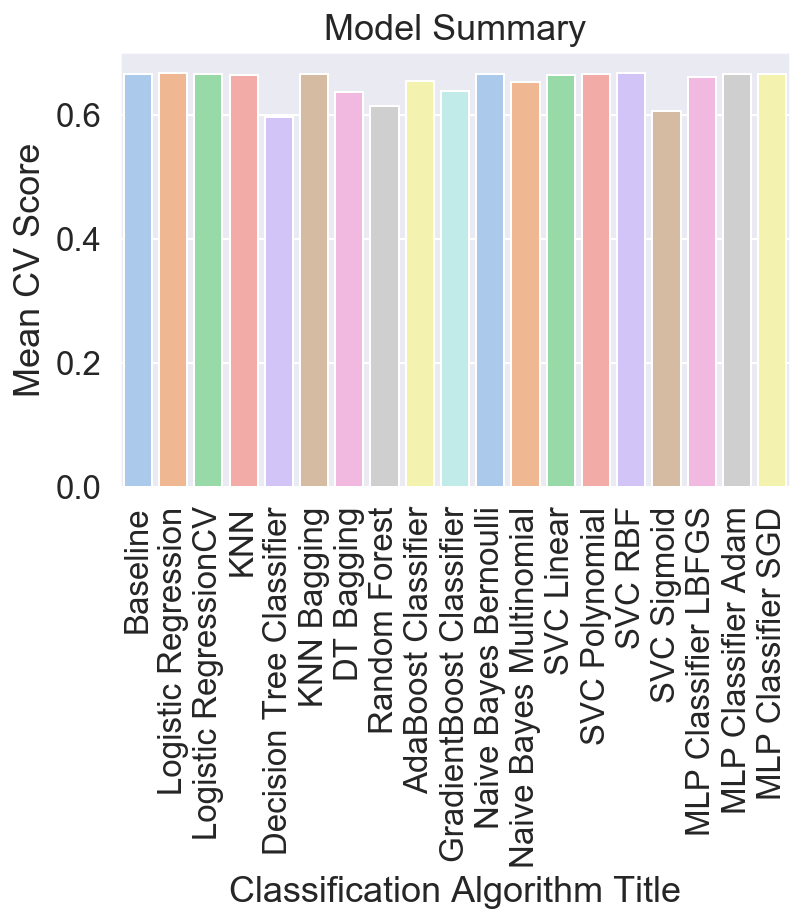

In [64]:
sns.barplot(x=summary_cv['Classification Algorithm Title'], y=summary_cv['Mean CV Score'], palette = 'pastel')
plt.title('Model Summary')
plt.xlabel('Classification Algorithm Title')
plt.ylabel('Mean CV Score')
plt.xticks(rotation='vertical');

The best 2 models according to Mean CV Score are Logistic Regression and SVC (rbf). I will Gridsearch on these 2 to see if I can improve them by tuning.

### Gridsearch on the best 2 models:

In [176]:
#1. Gridsearch Logistic Regression on Lasso and Ridge
lr = LogisticRegression(solver='lbfgs', max_iter=1000)

gs_params = {'penalty': ['l1', 'l2'], #test for different penalty tpes, either l1 or l2
             'solver': ['liblinear'], #set solver to liblinear because we need it for l1; the default solver won't work with l1
             'C': np.logspace(-3, 0, 50)}

lr_gridsearch = GridSearchCV(lr,
                             gs_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

lr_gridsearch.fit(X_train, y_train)

print('Parameter Grid', lr_gridsearch.param_grid)
print('Best score', lr_gridsearch.best_score_ )
print('Best estimator', lr_gridsearch.best_estimator_)
print('Best params', lr_gridsearch.best_params_)

best_lr = lr_gridsearch.best_estimator_
print('Best training score', best_lr.score(X_train, y_train))
print('Best test score', best_lr.score(X_test, y_test))

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   34.0s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  3.8min
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  5.5min finished


Parameter Grid {'penalty': ['l1', 'l2'], 'solver': ['liblinear'], 'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ])}
Best score 0.668236198529765
Best estimator LogisticRegression(C=0.044984326689694466, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='warn', n_jobs=Non

In [179]:
#1. Gridsearch Logistic Regression on Elastic Net
lr_en = LogisticRegression(solver='lbfgs', max_iter=1000)

gs_params = {'penalty': ['elasticnet'], #test for different penalty tpes, either l1 or l2
             'solver': ['saga'], #set solver to liblinear because we need it for l1; the default solver won't work with l1
             'C': np.logspace(-3, 0, 50),
            'l1_ratio': np.linspace(0, 1, num=10)}

lr_en_gridsearch = GridSearchCV(lr_en,
                             gs_params,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

lr_en_gridsearch.fit(X_train, y_train)

print('Parameter Grid', lr_en_gridsearch.param_grid)
print('Best score', lr_en_gridsearch.best_score_ )
print('Best estimator', lr_en_gridsearch.best_estimator_)
print('Best params', lr_en_gridsearch.best_params_)

best_lr_en = lr_en_gridsearch.best_estimator_
print('Best training score', best_lr_en.score(X_train, y_train))
print('Best test score', best_lr_en.score(X_test, y_test))

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   26.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  2.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  5.8min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 15.3min
[Parallel(n_jobs=2)]: Done 1246 tasks      | elapsed: 37.6min
[Parallel(n_jobs=2)]: Done 1796 tasks      | elapsed: 82.4min
[Parallel(n_jobs=2)]: Done 2446 tasks      | elapsed: 157.6min
[Parallel(n_jobs=2)]: Done 2500 out of 2500 | elapsed: 164.8min finished


Parameter Grid {'penalty': ['elasticnet'], 'solver': ['saga'], 'C': array([0.001     , 0.0011514 , 0.00132571, 0.00152642, 0.00175751,
       0.00202359, 0.00232995, 0.0026827 , 0.00308884, 0.00355648,
       0.00409492, 0.00471487, 0.00542868, 0.00625055, 0.00719686,
       0.00828643, 0.00954095, 0.01098541, 0.01264855, 0.01456348,
       0.01676833, 0.01930698, 0.02222996, 0.02559548, 0.02947052,
       0.03393222, 0.0390694 , 0.04498433, 0.05179475, 0.05963623,
       0.06866488, 0.07906043, 0.09102982, 0.10481131, 0.12067926,
       0.13894955, 0.15998587, 0.184207  , 0.21209509, 0.24420531,
       0.28117687, 0.32374575, 0.37275937, 0.42919343, 0.49417134,
       0.5689866 , 0.65512856, 0.75431201, 0.86851137, 1.        ]), 'l1_ratio': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])}
Best score 0.6682842454235334
Best estimator LogisticRegression(C=0.044984326689694466, class_weight=None, dual=

In [181]:
rbf = SVC(kernel='rbf')

gs_params_rbf = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001, 'scale', 'auto']}

rbf_gridsearch = GridSearchCV(rbf,
                             gs_params_rbf,
                             n_jobs=2, 
                             cv=5, 
                             verbose=1)

rbf_gridsearch.fit(X_train, y_train)

print('Parameter Grid', rbf_gridsearch.param_grid)
print('Best score', rbf_gridsearch.best_score_ )
print('Best estimator', rbf_gridsearch.best_estimator_)
print('Best params',rbf_gridsearch.best_params_)

best_rbf = rbf_gridsearch.best_estimator_
print('Best training score', best_rbf.score(X_train, y_train))
print('Best test score', best_rbf.score(X_test, y_test))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 16.0min
[Parallel(n_jobs=2)]: Done 120 out of 120 | elapsed: 83.9min finished


Parameter Grid {'C': [1, 10, 100, 1000], 'gamma': [1, 0.1, 0.001, 0.0001, 'scale', 'auto']}
Best score 0.6678518233796185
Best estimator SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Best params {'C': 100, 'gamma': 0.001}
Best training score 0.6758756546389276
Best test score 0.6642966948501153


In [208]:
#Ultimate best model from Gridsearch:
best = LogisticRegression(C=0.044984326689694466, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.0,
                   max_iter=1000, multi_class='warn', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)

best.fit(X_train, y_train)

train_best_predictions = best.predict(X_train)
test_best_predictions = best.predict(X_test)

print('Precision score', precision_score(y_test, test_best_predictions, average='micro'))
print('Recall score', (recall_score(y_test, test_best_predictions, average='micro')))
print('F1 score', f1_score(y_test, test_best_predictions, average='micro'))

print('Training score', best.score(X_train, y_train))
print('Testing score', best.score(X_test, y_test))

cv_scores = cross_val_score(best, X_train, y_train, cv=5, n_jobs=2)
print('CV scores', cv_scores)
print('Mean CV Score', np.mean(cv_scores))

Precision score 0.665641813989239
Recall score 0.665641813989239
F1 score 0.665641813989239
Training score 0.668524479892375
Testing score 0.665641813989239
CV scores [0.67675312 0.66330451 0.66922892 0.66450373 0.66762797]
Mean CV Score 0.6682836514898551


In [209]:
np.unique(test_best_predictions)

array([0, 1, 2])

In [210]:
print(confusion_matrix(y_test, test_best_predictions, labels=[0, 1, 2]))

[[3396   14   58]
 [ 613   13    7]
 [1039    9   55]]


In [212]:
print(classification_report(y_train, train_best_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.6737    0.9813    0.7989     13868
           1     0.4908    0.0316    0.0594      2532
           2     0.5011    0.0510    0.0926      4413

    accuracy                         0.6685     20813
   macro avg     0.5552    0.3546    0.3169     20813
weighted avg     0.6148    0.6685    0.5592     20813



In [213]:
print(classification_report(y_test, test_best_predictions, digits=4))

              precision    recall  f1-score   support

           0     0.6727    0.9792    0.7976      3468
           1     0.3611    0.0205    0.0389       633
           2     0.4583    0.0499    0.0899      1103

    accuracy                         0.6656      5204
   macro avg     0.4974    0.3499    0.3088      5204
weighted avg     0.5894    0.6656    0.5553      5204



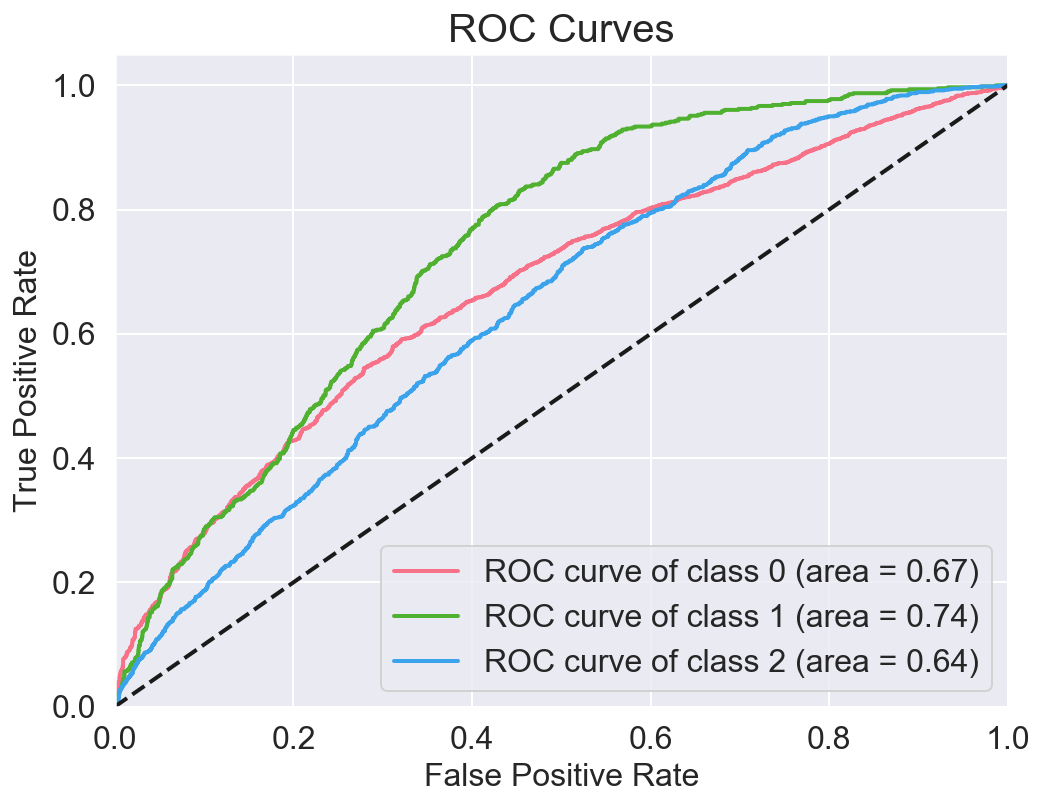

Area under ROC curve (ROC-AUC):
Class 0: 0.67
Class 1: 0.74
Class 2: 0.64


In [214]:
y_test_bin_best = label_binarize(y_test, best.classes_)

skplt.metrics.plot_roc(y_test, best.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
plt.show()

print('Area under ROC curve (ROC-AUC):')
for i, class_ in enumerate(best.classes_):
    print('Class {}:'.format(class_), round(metrics.roc_auc_score(
        y_test_bin_best[:, i], best.predict_proba(X_test)[:, i]), 2))

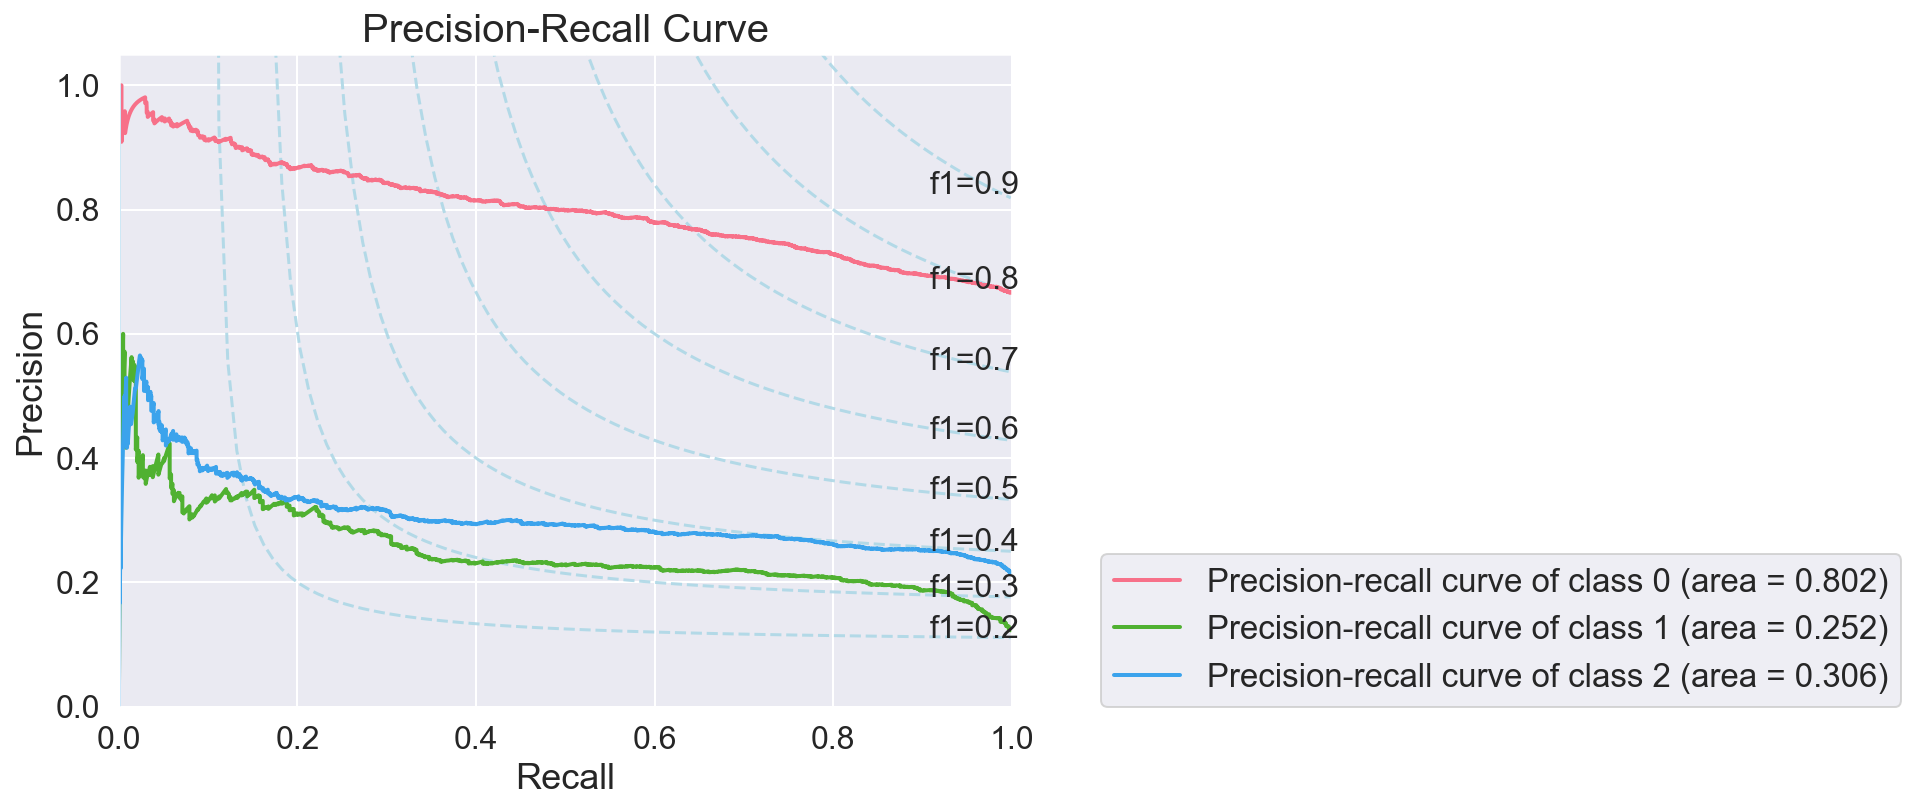

Areab under precision-recall curve:
Class 0: 0.8022
Class 1: 0.2517
Class 2: 0.3058


In [215]:
#Precision-Recall curve for Model 11
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, best.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
plt.show()

print('Areab under precision-recall curve:')
for i, class_ in enumerate(best.classes_):
    print('Class {}:'.format(class_), round(metrics.average_precision_score(
        y_test_bin_best[:, i], best.predict_proba(X_test)[:, i]), 4))

In [67]:
preds = pd.DataFrame({'Classification Algorithm Title': [
                                                           'Logistic Regression', 
                                                           'Logistic RegressionCV',
                                                          'KNN', 
                                                           'Decision Tree Classifier',
                                                           'KNN Bagging',
                                                          'DT Bagging', 
                                                           'Random Forest', 
                                                           'AdaBoost Classifier',
                                                          'GradientBoost Classifier',
                                                           'Naive Bayes Bernoulli', 
                                                          'Naive Bayes Multinomial',
                                                           'SVC Linear',
                                                           'SVC Polynomial',
                                                          'SVC RBF',
                                                           'SVC Sigmoid',
                                                          'MLP Classifier LBFGS',
                                                          'MLP Classifier Adam',
                                                          'MLP Classifier SGD',
                                                          'Neural Net Tensorflow',
                                                        ],
                        
                        'Precision Score' : [
                                            prec_1,
                                             prec_2,
                                             prec_3,
                                             prec_4,
                                             prec_5,
                                             prec_6,
                                             prec_7,
                                             prec_8,
                                             prec_9,
                                             prec_10,
                                             prec_11,
                                             prec_12,
                                             prec_13,
                                             prec_14,
                                             prec_15,
                                             prec_16,
                                             prec_17,
                                             prec_18,
                                             prec_19
                                             ]})

In [68]:
preds.to_csv('preds.csv', index=False)

In [69]:
recall = pd.DataFrame({'Classification Algorithm Title': [
                                                           'Logistic Regression', 
                                                           'Logistic RegressionCV',
                                                          'KNN', 
                                                           'Decision Tree Classifier',
                                                           'KNN Bagging',
                                                          'DT Bagging', 
                                                           'Random Forest', 
                                                           'AdaBoost Classifier',
                                                          'GradientBoost Classifier',
                                                           'Naive Bayes Bernoulli', 
                                                          'Naive Bayes Multinomial',
                                                           'SVC Linear',
                                                           'SVC Polynomial',
                                                          'SVC RBF',
                                                           'SVC Sigmoid',
                                                          'MLP Classifier LBFGS',
                                                          'MLP Classifier Adam',
                                                          'MLP Classifier SGD',
                                                          'Neural Net Tensorflow',
                                                      
                        
                        'Recall Score': [rec_1,
                                             rec_2,
                                             rec_3,
                                             rec_4,
                                             rec_5,
                                             rec_6,
                                             rec_7,
                                             rec_8,
                                             rec_9,
                                             rec_10,
                                             rec_11,
                                             rec_12,
                                             rec_13,
                                             rec_14,
                                             rec_15,
                                             rec_16,
                                             rec_17,
                                             rec_18,
                                         rec_19
                                             ]})
                       

In [70]:
recall.to_csv('recall.csv', index=False)

In [8]:
#Training and Test
traintest = pd.DataFrame({'Classification Algorithm Title': [
                                                           'Logistic Regression', 
                                                           'Logistic RegressionCV',
                                                          'KNN', 
                                                           'Decision Tree Classifier',
                                                           'KNN Bagging',
                                                          'DT Bagging', 
                                                           'Random Forest', 
                                                           'AdaBoost Classifier',
                                                          'GradientBoost Classifier',
                                                           'Naive Bayes Bernoulli', 
                                                          'Naive Bayes Multinomial',
                                                           'SVC Linear',
                                                           'SVC Polynomial',
                                                          'SVC RBF',
                                                           'SVC Sigmoid',
                                                          'MLP Classifier LBFGS',
                                                          'MLP Classifier Adam',
                                                          'MLP Classifier SGD'],
    
                                                      'Training score': [train_1,
                                             train_2,
                                             train_3,
                                             train_4,
                                             train_5,
                                             train_6,
                                             train_7,
                                            train_8,
                                             train_9,
                                             train_10,
                                             train_11,
                                             train_12,
                                             train_13,
                                             train_14,
                                             train_15,
                                             train_16,
                                             train_17,
                                             train_18,
                                             ],
                        
                       'Testing score': [test_1,
                                             test_2,
                                             test_3,
                                             test_4,
                                             test_5,
                                             test_6,
                                             test_7,
                                             test_8,
                                             test_9,
                                            test_10,
                                             test_11,
                                             test_12,
                                             test_13,
                                             test_14,
                                             test_15,
                                             test_16,
                                             test_17,
                                             test_18,
                                             ]})

In [9]:
traintest.to_csv('traintest.csv', index=False)

### Findings
Out of 15 models tested, 4 achieved a mean CV score higher than baseline, but even this was only by 0.001 if that. The highest of these was Logistic Regression with a score of 0.6677552210032934.

Tuning by changing penalties improved this marginally - 

Ridge:0.6677552325574606
Lasso:0.6679474478496719
ElasticNet:0.6679954785893453

Gridsearching provided a slightly improved model with a best score of 0.6682842454235334. The final best model was:

LogisticRegression(C=0.044984326689694466, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=0.0,
                   max_iter=1000, multi_class='warn', n_jobs=None,
                   penalty='elasticnet', random_state=None, solver='saga',
                   tol=0.0001, verbose=0, warm_start=False)
                   
Most important feature was consistently Average Release Age.

### Interpretations & Inferences
The fact that none of the scores achieved were even 1% higher than baseline

### Risks/Limitations/Assumptions of these findings